In [7]:
import numpy as np
import matplotlib.pyplot as plt


from hnc import  HNC_solver
from qsps import *


In [3]:
def run_hnc(n_in_per_cc, T, Z, A, Zstar, num_iterations=1e3, alpha = 1e-3, c_k_guess=None , which_Tij='thermal', method='best'):
    ri = QSP_HNC.rs_from_n(n_in_per_cc*1e6 *aB**3)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri, which_Tij=which_Tij)

    N_species = 2
    Gamma = np.array(  [[qsp.Γii,  qsp.Γei],
                        [qsp.Γei,  qsp.Γee]])


    names = ["Ion-1", "Electron", ] 
    kappa = 1
    rhos = np.array([  3/(4*np.pi), Zstar*3/(4*np.pi) ])
    temps = qsp.Tij
    masses= qsp.mij
#     hnc1 = HNC_solver(N_species, Gamma, rhos, temps, masses , tol=1e-5,
#                      kappa_multiscale=1, num_iterations=int(num_iterations), 
#                      R_max=5, N_bins=N_bins, names=names, dst_type=3)

    hnc1 = HNC_solver(N_species, Gamma, rhos, tol=1e-5,
                     kappa_multiscale=4, num_iterations=int(num_iterations), 
                     R_max=5, N_bins=N_bins, names=names, dst_type=3)

    βu_r_matrix = np.array([[qsp.βvii(hnc1.r_array), qsp.βvei(hnc1.r_array)],
                            [qsp.βvei(hnc1.r_array), qsp.βvee(hnc1.r_array)]])

    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    if c_k_guess is not None:
        for i in range(N_species):
            for j in range(N_species):
                if (c_k_guess[i,j]!=np.zeros(hnc1.N_bins)).all():
#                 if i==j:
                    hnc1.c_k_matrix[i,j] = c_k_guess[i,j]
                    hnc1.c_r_matrix[i,j] = hnc1.FT_k_2_r(hnc1.c_k_matrix[i,j])
                    hnc1.c_s_k_matrix[i,j] = hnc1.c_k_matrix[i,j] + hnc1.βu_l_k_matrix[i,j]
                    hnc1.c_s_r_matrix[i,j] = hnc1.c_r_matrix[i,j] + hnc1.βu_l_r_matrix[i,j]

#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e8)

    return hnc1, qsp

In [4]:
def run_hnc_one_ion(n_in_per_cc, T, Z, A, Zstar, num_iterations=1e3, alpha = 1e-3,method='best', which_Tij='thermal' ):
    ri = QSP_HNC.rs_from_n(n_in_per_cc*1e6 *aB**3)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri, which_Tij=which_Tij)

    N_species = 1
    Gamma = np.array(  [[qsp.Γii]])


    names = ["i"] 
    kappa = 1
    rho = np.array([  3/(4*np.pi)])
    temps = np.array([[qsp.Ti]])
    masses= np.array([[qsp.m_i]])
#     hnc1 = HNC_solver(N_species, Gamma,rho, temps,masses, kappa=kappa, tol=1e-5,
#                      kappa_multiscale=1, num_iterations=int(num_iterations), 
#                      R_max=5, N_bins=N_bins, names=names, dst_type=3)

    hnc1 = HNC_solver(N_species, Gamma,rho, kappa=kappa, tol=1e-5,
                     kappa_multiscale=1, num_iterations=int(num_iterations), 
                     R_max=5, N_bins=N_bins, names=names, dst_type=3)

    βu_r_matrix = np.array([[qsp.βvii(hnc1.r_array)]])

    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e4)
    return hnc1, qsp

def run_hnc_one_electron(n_in_per_cc, T, Z, A, Zstar, num_iterations=1e3, alpha = 1e-3,method='best' , which_Tij='thermal'):
    ri = QSP_HNC.rs_from_n(n_in_per_cc*1e6 *aB**3)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri, which_Tij=which_Tij)

    N_species = 1
    Gamma = np.array(  [[qsp.Γii]])


    names = ["e"] 
    kappa = 1
    rho = np.array([  Zstar*3/(4*np.pi)])
    temps = np.array([[qsp.Te_c]])
    masses= np.array([[m_e]])
#     hnc1 = HNC_solver(N_species, Gamma,rho, temps,masses, kappa=kappa, tol=1e-5,
#                      kappa_multiscale=1, num_iterations=int(num_iterations), 
#                      R_max=5, N_bins=N_bins, names=names, dst_type=3)

    hnc1 = HNC_solver(N_species, Gamma,rho, kappa=kappa, tol=1e-5,
                     kappa_multiscale=1, num_iterations=int(num_iterations), 
                     R_max=5, N_bins=N_bins, names=names, dst_type=3)

    βu_r_matrix = np.array([[qsp.βvee(hnc1.r_array)]])

    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e4)
    return hnc1, qsp



# Priority 1
## Carbon

In [9]:
ni = 5.01e23 # per cc
Te = 2*eV 
Ti   = 2*eV 
Z, A = 6,12
Zstar= 3

# c_s_r_guess = np.zeros((2,2,N_bins))
# c_s_r_guess[0,0] = carbon_one_species.c_s_r_matrix

carbon, carbonqsp = run_hnc(ni, Te, Z, A, Zstar ,method='fixed',alpha=0.5,num_iterations=1e3)#, c_s_r_guess=c_s_r_guess)


Λee = 0.328
Λei = 0.232
Γii=82.957, Γie=-1.499, Γee=0.500 
r_i=1.476
r_e=1.023
θ  =4.18e-02
0: Err in c_r: 9.03e+01, OZ: 2.02e-01, HNC: 1.16e-01, tot: 0.20
1: Err in c_r: 5.23e+01, OZ: 1.89e-01, HNC: 5.55e-02, tot: 0.20
2: Err in c_r: 3.04e+01, OZ: 1.80e-01, HNC: 5.23e-02, tot: 0.21
3: Err in c_r: 1.80e+01, OZ: 1.74e-01, HNC: 6.38e-02, tot: 0.24
4: Err in c_r: 1.10e+01, OZ: 1.71e-01, HNC: 8.59e-02, tot: 0.28
5: Err in c_r: 7.07e+00, OZ: 1.69e-01, HNC: 1.18e-01, tot: 0.32
6: Err in c_r: 4.83e+00, OZ: 1.68e-01, HNC: 1.47e-01, tot: 0.36
7: Err in c_r: 3.51e+00, OZ: 1.66e-01, HNC: 1.71e-01, tot: 0.40
8: Err in c_r: 2.70e+00, OZ: 1.64e-01, HNC: 1.89e-01, tot: 0.44
9: Err in c_r: 2.18e+00, OZ: 1.62e-01, HNC: 2.04e-01, tot: 0.47
10: Err in c_r: 1.82e+00, OZ: 1.59e-01, HNC: 2.18e-01, tot: 0.50
11: Err in c_r: 1.56e+00, OZ: 1.57e-01, HNC: 2.31e-01, tot: 0.53
12: Err in c_r: 1.37e+00, OZ: 1.54e-01, HNC: 2.44e-01, tot: 0.56
13: Err in c_r: 1.22e+00, OZ: 1.51e-01, HNC: 2.57e-01, tot: 0.59
14: Err 

169: Err in c_r: 3.16e-03, OZ: 2.42e-03, HNC: 1.03e-02, tot: 2.05
170: Err in c_r: 3.07e-03, OZ: 2.35e-03, HNC: 1.00e-02, tot: 2.05
171: Err in c_r: 2.99e-03, OZ: 2.29e-03, HNC: 9.75e-03, tot: 2.05
172: Err in c_r: 2.90e-03, OZ: 2.22e-03, HNC: 9.47e-03, tot: 2.05
173: Err in c_r: 2.82e-03, OZ: 2.16e-03, HNC: 9.19e-03, tot: 2.05
174: Err in c_r: 2.74e-03, OZ: 2.10e-03, HNC: 8.93e-03, tot: 2.05
175: Err in c_r: 2.66e-03, OZ: 2.04e-03, HNC: 8.67e-03, tot: 2.05
176: Err in c_r: 2.58e-03, OZ: 1.98e-03, HNC: 8.43e-03, tot: 2.05
177: Err in c_r: 2.51e-03, OZ: 1.93e-03, HNC: 8.19e-03, tot: 2.05
178: Err in c_r: 2.44e-03, OZ: 1.87e-03, HNC: 7.95e-03, tot: 2.05
179: Err in c_r: 2.37e-03, OZ: 1.82e-03, HNC: 7.72e-03, tot: 2.05
180: Err in c_r: 2.30e-03, OZ: 1.77e-03, HNC: 7.50e-03, tot: 2.05
181: Err in c_r: 2.23e-03, OZ: 1.72e-03, HNC: 7.29e-03, tot: 2.05
182: Err in c_r: 2.17e-03, OZ: 1.67e-03, HNC: 7.08e-03, tot: 2.05
183: Err in c_r: 2.11e-03, OZ: 1.62e-03, HNC: 6.88e-03, tot: 2.05
184: Err i

343: Err in c_r: 2.13e-05, OZ: 1.65e-05, HNC: 6.93e-05, tot: 2.06
344: Err in c_r: 2.07e-05, OZ: 1.60e-05, HNC: 6.74e-05, tot: 2.06
345: Err in c_r: 2.01e-05, OZ: 1.56e-05, HNC: 6.55e-05, tot: 2.06
346: Err in c_r: 1.95e-05, OZ: 1.52e-05, HNC: 6.36e-05, tot: 2.06
347: Err in c_r: 1.90e-05, OZ: 1.47e-05, HNC: 6.18e-05, tot: 2.06
348: Err in c_r: 1.84e-05, OZ: 1.43e-05, HNC: 6.01e-05, tot: 2.06
349: Err in c_r: 1.79e-05, OZ: 1.39e-05, HNC: 5.84e-05, tot: 2.06
350: Err in c_r: 1.74e-05, OZ: 1.35e-05, HNC: 5.67e-05, tot: 2.06
351: Err in c_r: 1.69e-05, OZ: 1.31e-05, HNC: 5.51e-05, tot: 2.06
352: Err in c_r: 1.64e-05, OZ: 1.28e-05, HNC: 5.36e-05, tot: 2.06
353: Err in c_r: 1.60e-05, OZ: 1.24e-05, HNC: 5.21e-05, tot: 2.06
354: Err in c_r: 1.55e-05, OZ: 1.20e-05, HNC: 5.06e-05, tot: 2.06
355: Err in c_r: 1.51e-05, OZ: 1.17e-05, HNC: 4.92e-05, tot: 2.06
356: Err in c_r: 1.46e-05, OZ: 1.14e-05, HNC: 4.78e-05, tot: 2.06
357: Err in c_r: 1.42e-05, OZ: 1.11e-05, HNC: 4.64e-05, tot: 2.06
358: Err i

In [11]:
- 1 - carbon.c_s_k_matrix  - carbon.γs_k_matrix   + np.exp( -carbon.βu_s_r_matrix  + carbon.γs_r_matrix  )

array([[[3.18679084e+00, 3.17018086e+00, 3.12081037e+00, ...,
         3.31361078e-02, 3.31317627e-02, 3.30854255e-02],
        [3.07428457e+01, 2.67888345e+01, 2.34128902e+01, ...,
         6.30991551e-03, 6.31121840e-03, 6.30322191e-03]],

       [[3.07428457e+01, 2.67888345e+01, 2.34128902e+01, ...,
         6.30991551e-03, 6.31121840e-03, 6.30322191e-03],
        [7.91828095e-01, 5.79904558e-01, 2.83034434e-01, ...,
         1.09099693e-03, 1.09149282e-03, 1.09020126e-03]]])

In [18]:
carbon.c_k_list[1]

array([[[-1.05603924e+04, -1.17163156e+03, -4.20539732e+02, ...,
         -8.16477203e-06, -4.89393934e-06, -1.62967804e-06],
        [ 1.89880804e+02,  2.02429138e+01,  6.74135169e+00, ...,
          8.30852232e-11,  4.98011296e-11,  1.65831817e-11]],

       [[ 1.89880804e+02,  2.02429138e+01,  6.74135169e+00, ...,
          8.30852232e-11,  4.98011296e-11,  1.65831817e-11],
        [-6.33251670e+01, -6.80029806e+00, -2.32630829e+00, ...,
         -3.46243008e-12, -2.14941719e-12, -6.54089422e-13]]])

In [17]:
carbon.c_k_list[0]

array([[[-1.05623591e+04, -1.17359353e+03, -4.22492281e+02, ...,
         -1.63293959e-05, -9.78779300e-06, -3.25932807e-06],
        [ 1.89878897e+02,  2.02410170e+01,  6.73947396e+00, ...,
          3.42262260e-11,  2.05154702e-11,  6.83112303e-12]],

       [[ 1.89878897e+02,  2.02410170e+01,  6.73947396e+00, ...,
          3.42262260e-11,  2.05154702e-11,  6.83112303e-12],
        [-6.33961669e+01, -6.86879907e+00, -2.39021245e+00, ...,
         -5.65831216e-12, -3.46560975e-12, -1.09238037e-12]]])

In [19]:
carbon.c_k_list[-1]

array([[[-1.03787164e+04, -1.00085956e+03, -2.68333115e+02, ...,
          6.78530916e-11, -6.77844079e-11,  6.77165668e-11],
        [ 1.90431740e+02,  2.07269559e+01,  7.14827801e+00, ...,
          1.24498458e-09,  7.42262022e-10,  2.50477204e-10]],

       [[ 1.90431740e+02,  2.07269559e+01,  7.14827801e+00, ...,
          1.24498458e-09,  7.42262021e-10,  2.50477204e-10],
        [-6.32750116e+01, -6.75573452e+00, -2.29059393e+00, ...,
         -2.26551334e-12, -1.55108917e-12, -3.55700573e-13]]])

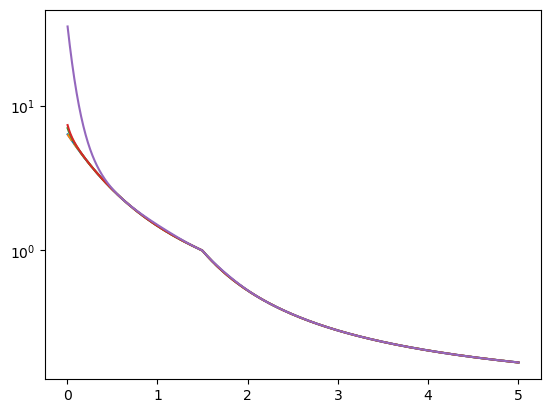

In [13]:
fig, ax = plt.subplots()
ax.plot(carbon.r_array,carbon.c_list[0][0,1])
ax.plot(carbon.r_array,-carbon.βu_r_matrix[0,1],'--')
ax.plot(carbon.r_array,carbon.c_list[1][0,1])
ax.plot(carbon.r_array,carbon.c_list[2][0,1])
ax.plot(carbon.r_array,carbon.c_list[-1][0,1])
ax.set_yscale('symlog', linthresh=1)

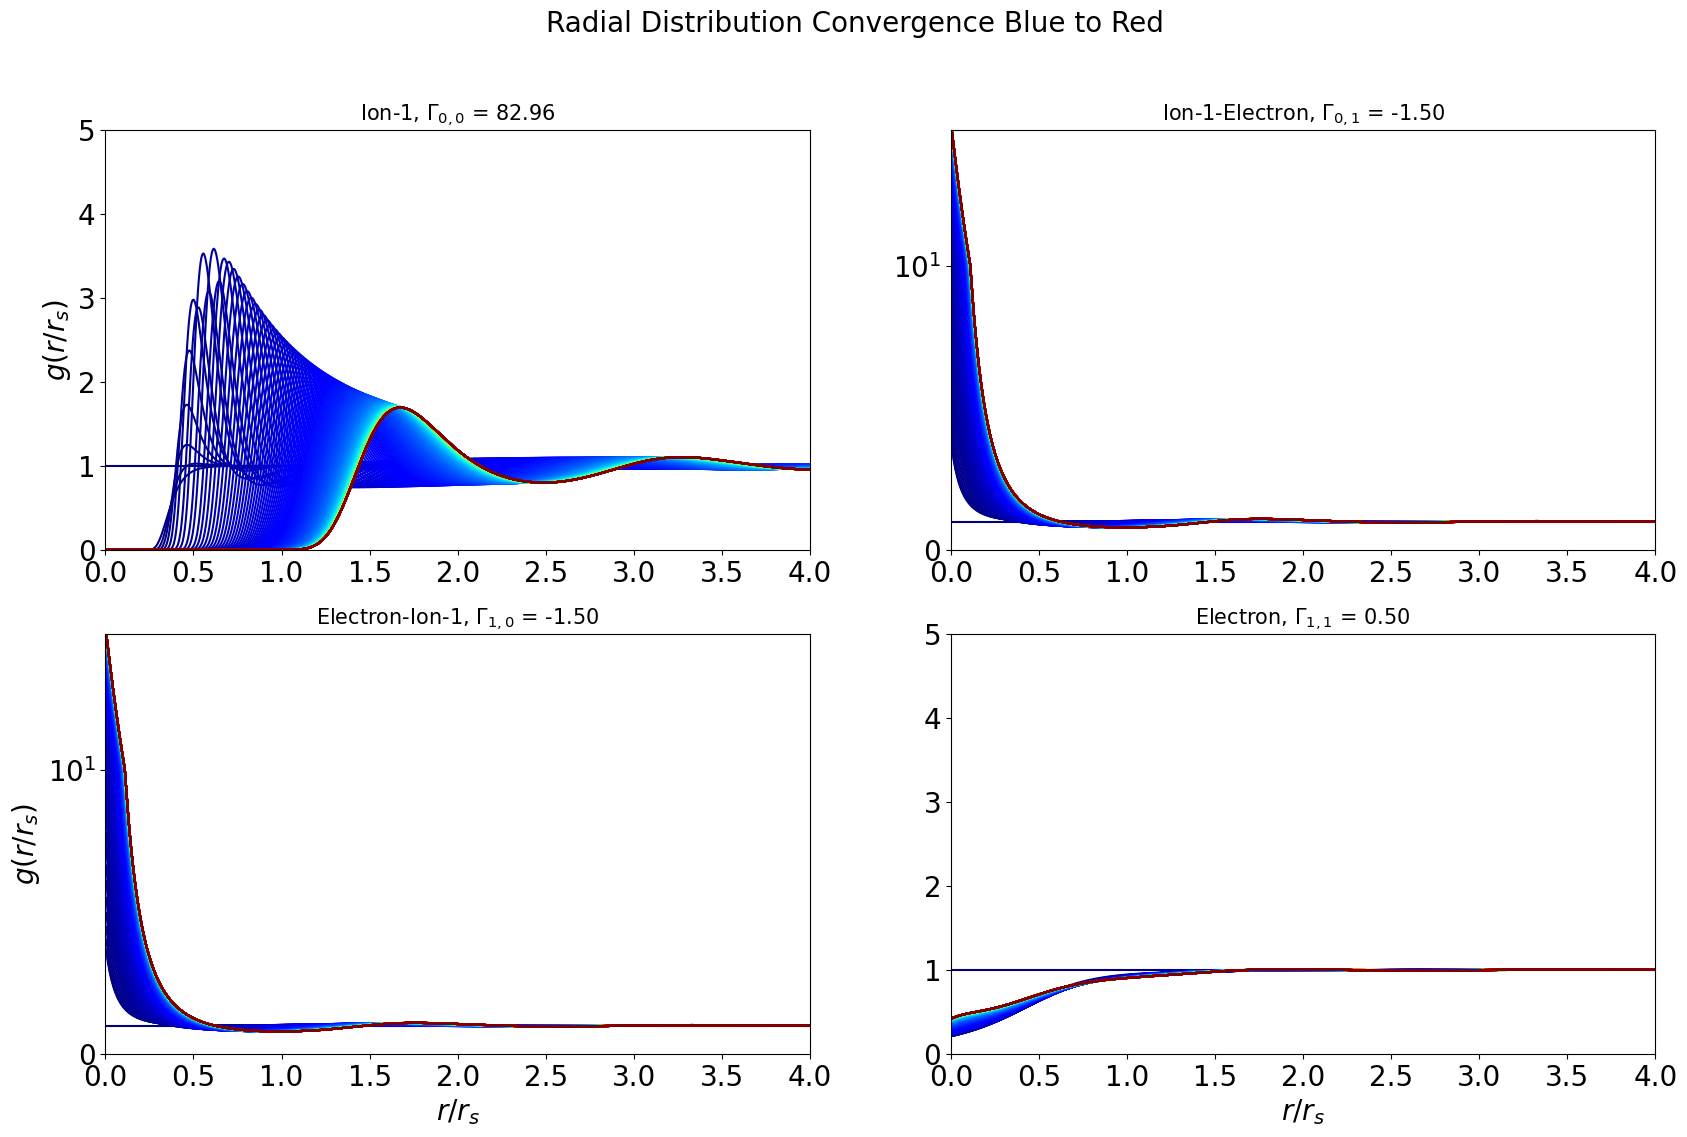

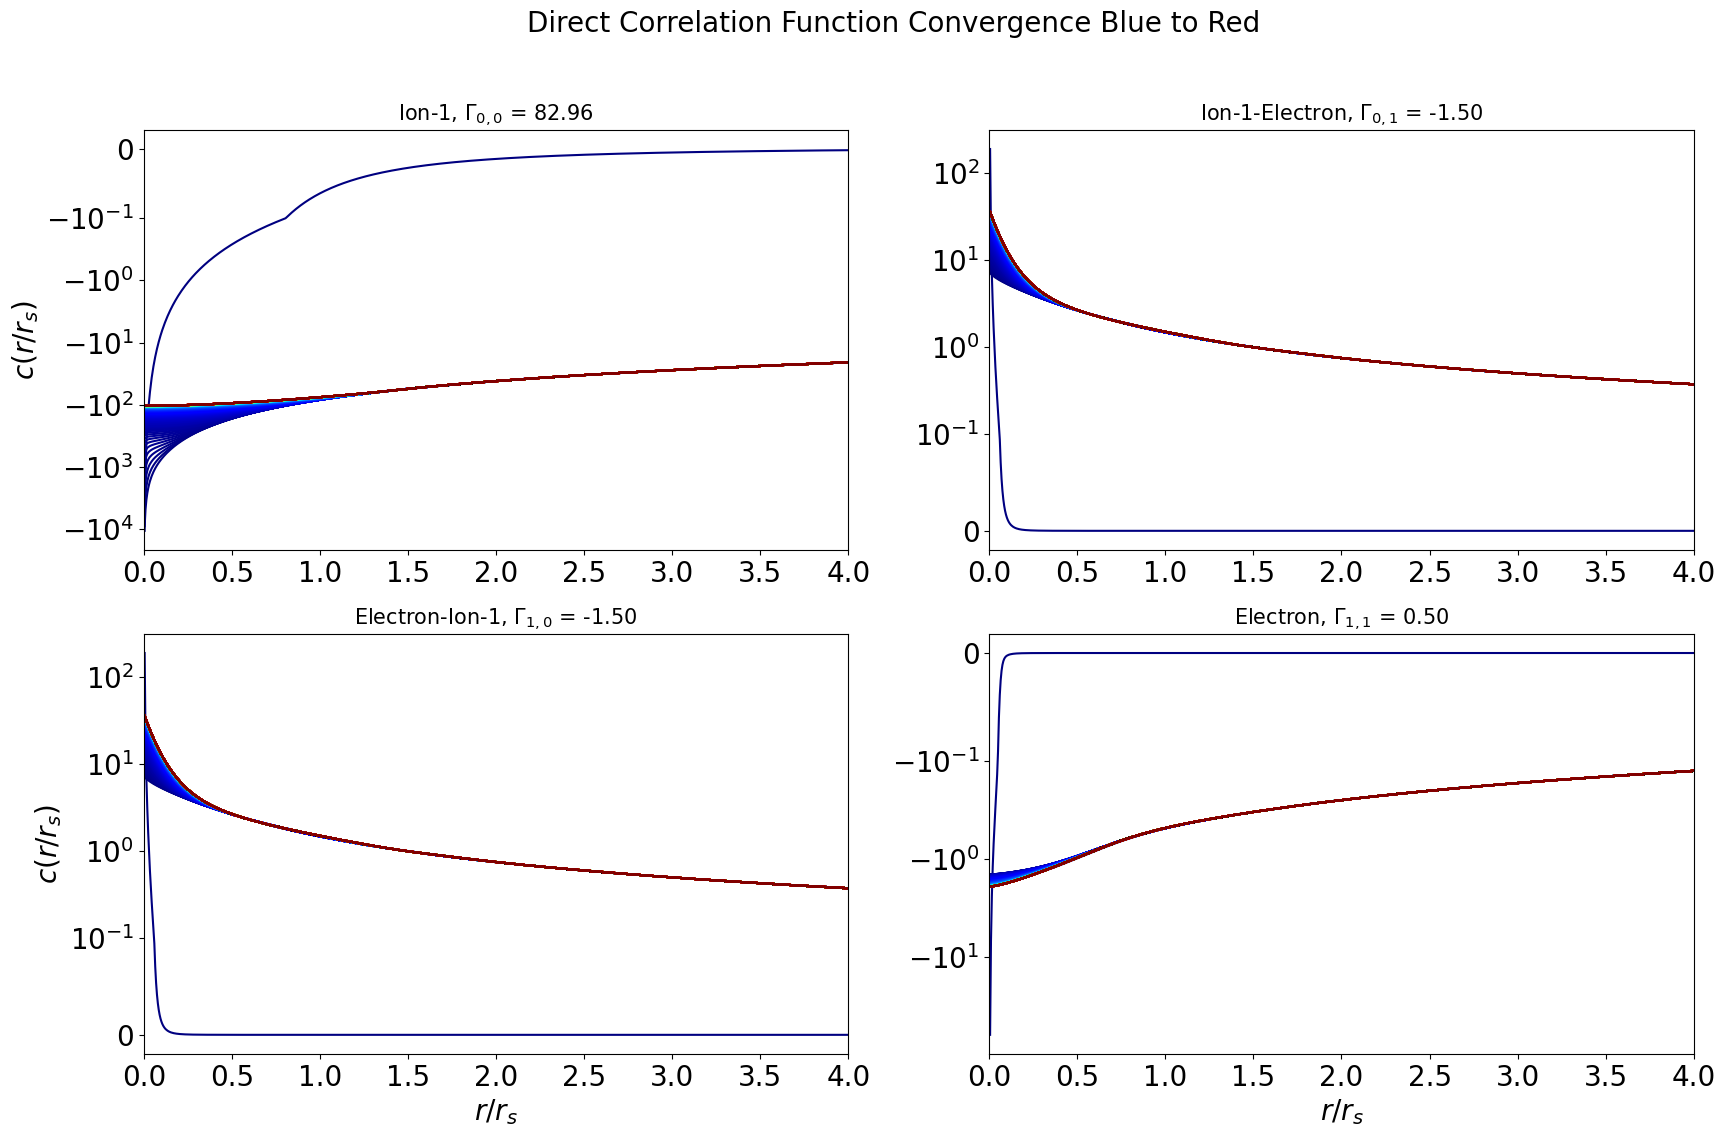

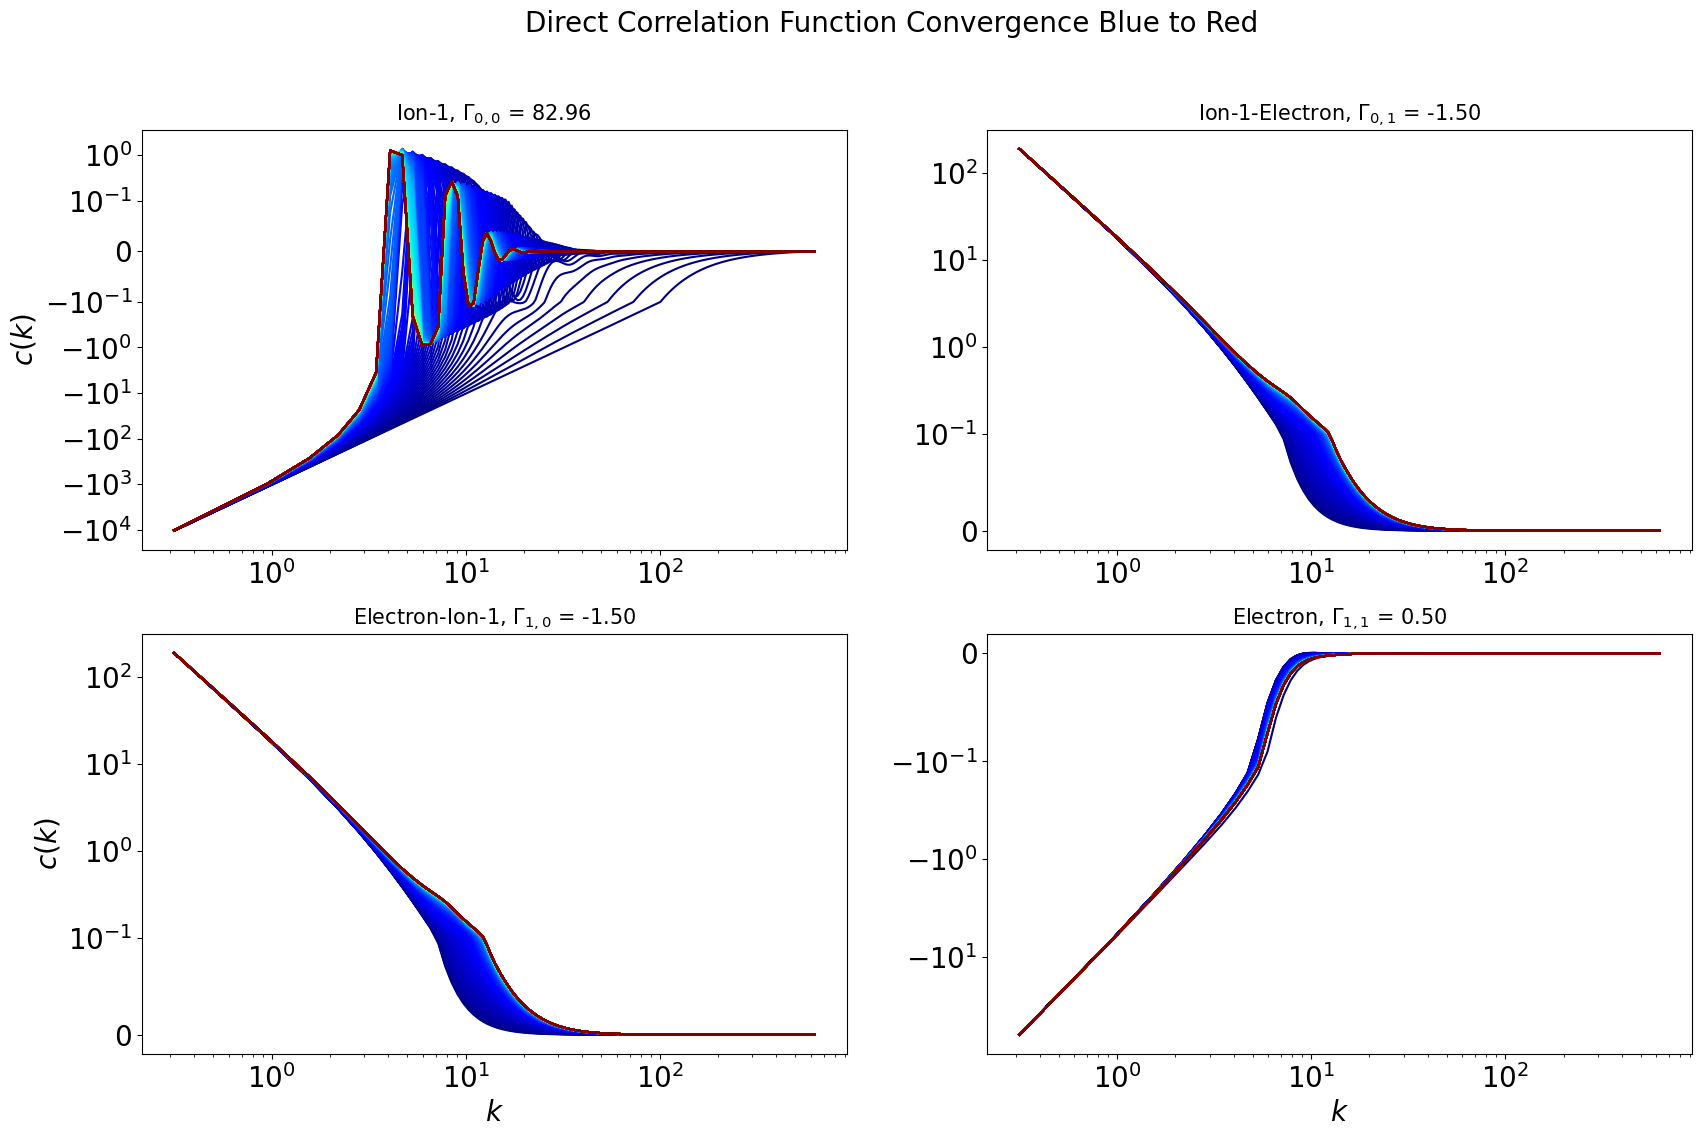

In [15]:
carbon.plot_species_convergence_g(n_slices= int(len(carbon.h_list)/1)  )
carbon.plot_species_convergence_c(n_slices= int(len(carbon.h_list)/1)  )
carbon.plot_species_convergence_ck(n_slices= int(len(carbon.h_list)/1)  )

In [16]:
carbon_one_species, _ = run_hnc_one_species(ni, Te, Z, A, Zstar )

NameError: name 'run_hnc_one_species' is not defined

In [ ]:
carbon.plot_g_vs_murillo()
carbon.plot_g_vs_murillo(gmax=3)

In [ ]:
fig, ax = plt.subplots()

ax.plot(carbon.r_array, carbon.h_r_matrix[0,0]+1, label='Ion and Electron')
ax.plot(carbon.r_array, carbon_one_species.h_r_matrix[0,0]+1, label="Ion only")
ax.legend()



## Copper

In [24]:
ni = 8.49e22 # per cc
Te = 1*eV 
Ti   = 1*eV 
Z, A = 29,63.55
Zstar= 1.206


copper,_ = run_hnc(ni, Te, Z, A, Zstar ,num_iterations=1e3, method='best')

Λee = 0.417
Λei = 0.295
Γii=14.837, Γie=-1.761, Γee=1.460 
r_i=2.667
r_e=2.506
θ  =1.25e-01
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
0: Err in c_r: 2.77e+01, OZ: 8.27e-02, HNC: 1.25e+00
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
1: Err in c_r: 1.45e+01, OZ: 7.46e-02, HNC: 4.17e-01
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
2: Err in c_r: 7.62e+00, OZ: 6.83e-02, HNC: 4.31e-01
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
3: Err in c_r: 4.04e+00, OZ: 6.31e-02, HNC: 5.63e-01
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
4: Err in c_r: 2.18e+00, OZ: 5.86e-02, HNC: 7.35e-01
 HNC min: [0.5] True Optimization terminated successfully.

 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
48: Err in c_r: 1.35e-03, OZ: 5.65e-04, HNC: 1.01e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
49: Err in c_r: 1.21e-03, OZ: 5.03e-04, HNC: 8.99e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
50: Err in c_r: 1.07e-03, OZ: 4.48e-04, HNC: 8.00e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
51: Err in c_r: 9.55e-04, OZ: 3.99e-04, HNC: 7.12e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
52: Err in c_r: 8.50e-04, OZ: 3.55e-04, HNC: 6.33e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
53: Err in c_r: 7.56e-04, OZ

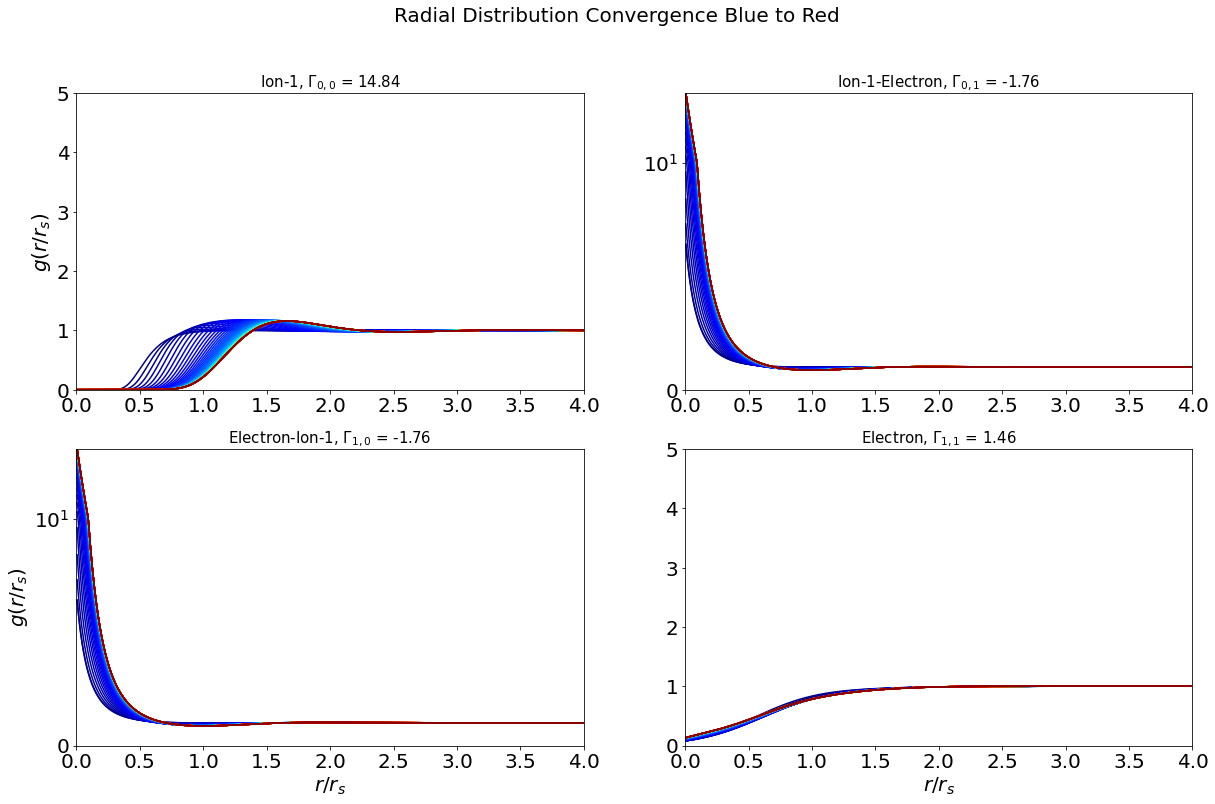

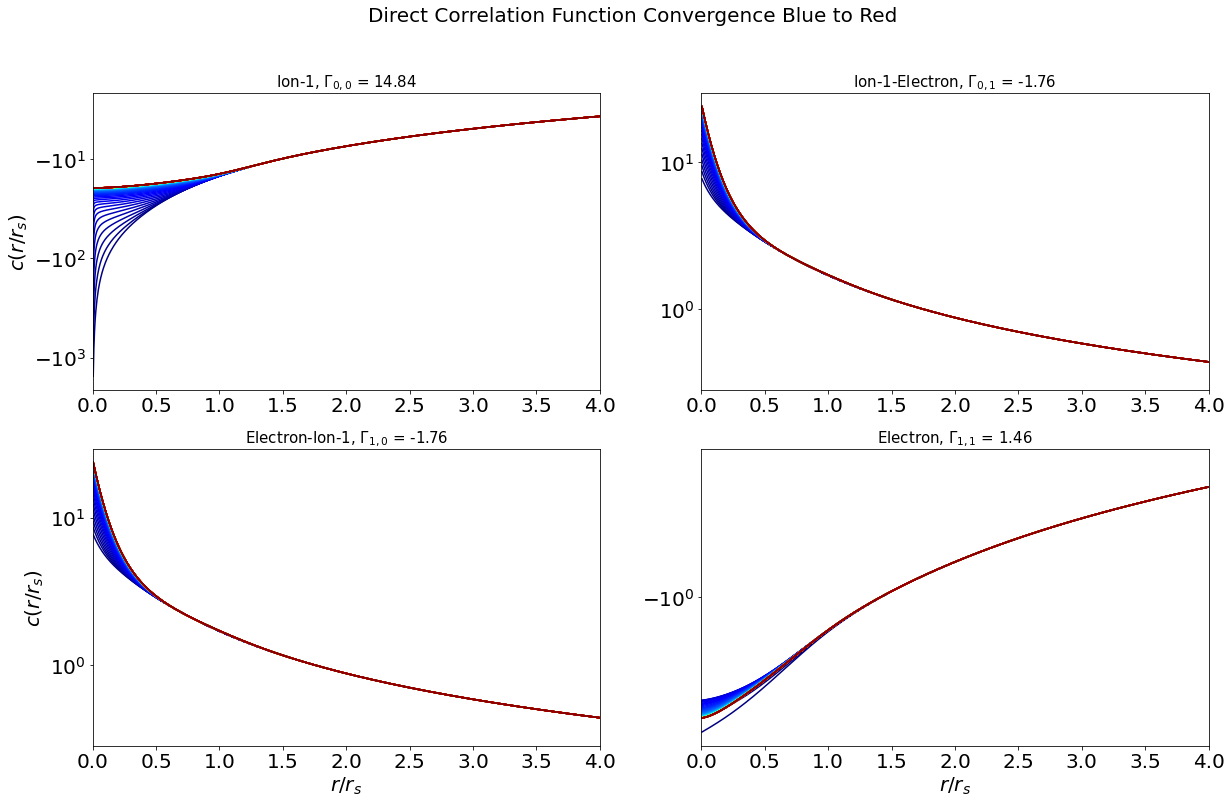

In [25]:
copper.plot_species_convergence_g(n_slices= int(len(copper.h_list)/1)  )
copper.plot_species_convergence_c(n_slices= int(len(copper.h_list)/1)  )

In [26]:
copper_one_species,_ = run_hnc_one_species(ni, Te, Z, A, Zstar )

Λee = 0.417
Λei = 0.295
Γii=14.837, Γie=-1.761, Γee=1.460 
r_i=2.667
r_e=2.506
θ  =1.25e-01
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.00313886] True Optimization terminated successfully.
0: Err in c_r: 5.56e+01, OZ: 1.54e-01, HNC: 1.60e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
1: Err in c_r: 2.90e+01, OZ: 1.45e-01, HNC: 1.15e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
2: Err in c_r: 1.52e+01, OZ: 1.34e-01, HNC: 9.94e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
3: Err in c_r: 8.05e+00, OZ: 1.25e-01, HNC: 9.62e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
4: Err in c_r: 4.34e+00, OZ: 1.17e-01, HNC: 9.65e-03
 HNC min: [0.5] True Optimization terminated succe

 OZ min:  [0.] True Optimization terminated successfully.
52: Err in c_r: 2.06e-03, OZ: 9.59e-04, HNC: 9.72e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
53: Err in c_r: 1.85e-03, OZ: 8.61e-04, HNC: 8.72e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
54: Err in c_r: 1.66e-03, OZ: 7.72e-04, HNC: 7.82e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
55: Err in c_r: 1.49e-03, OZ: 6.93e-04, HNC: 7.02e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
56: Err in c_r: 1.34e-03, OZ: 6.22e-04, HNC: 6.29e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
57: Err in c_r: 1.20e-03, OZ: 5.58e-04, HNC: 5.65e-05
 HNC min: [0.5] True Optimization

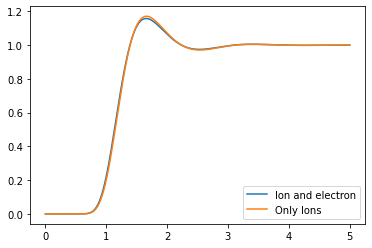

In [27]:
fig, ax = plt.subplots()

ax.plot(copper.r_array, copper.h_r_matrix[0,0]+1, label='Ion and electron')
ax.plot(copper.r_array, copper_one_species.h_r_matrix[0,0]+1, label="Only Ions")
ax.legend()



## Hydrogen

In [28]:
ni = 5.98e23 # per cc
Te = 2*eV 
Ti   = 2*eV 
Z, A = 1,1
Zstar= 1
hydrogen, _ = run_hnc(ni, Te, Z, A, Zstar )

Λee = 0.465
Λei = 0.329
Γii=9.778, Γie=-0.944, Γee=0.944 
r_i=1.391
r_e=1.391
θ  =7.73e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
0: Err in c_r: 1.85e+01, OZ: 6.96e-02, HNC: 6.19e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
1: Err in c_r: 9.61e+00, OZ: 6.15e-02, HNC: 3.84e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
2: Err in c_r: 5.00e+00, OZ: 5.48e-02, HNC: 3.24e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
3: Err in c_r: 2.62e+00, OZ: 4.93e-02, HNC: 3.17e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
4: Err in c_r: 1.39e+00, OZ: 4.44e-02, HNC: 3.22e-02
 HNC min: [0.5] True Optimization terminated successfully.


 OZ min:  [0.] True Optimization terminated successfully.
48: Err in c_r: 2.26e-04, OZ: 9.92e-05, HNC: 8.41e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
49: Err in c_r: 1.95e-04, OZ: 8.57e-05, HNC: 7.26e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
50: Err in c_r: 1.69e-04, OZ: 7.40e-05, HNC: 6.27e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
51: Err in c_r: 1.46e-04, OZ: 6.39e-05, HNC: 5.41e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
52: Err in c_r: 1.26e-04, OZ: 5.52e-05, HNC: 4.68e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
53: Err in c_r: 1.09e-04, OZ: 4.77e-05, HNC: 4.04e-05
 HNC min: [0.5] True Optimization

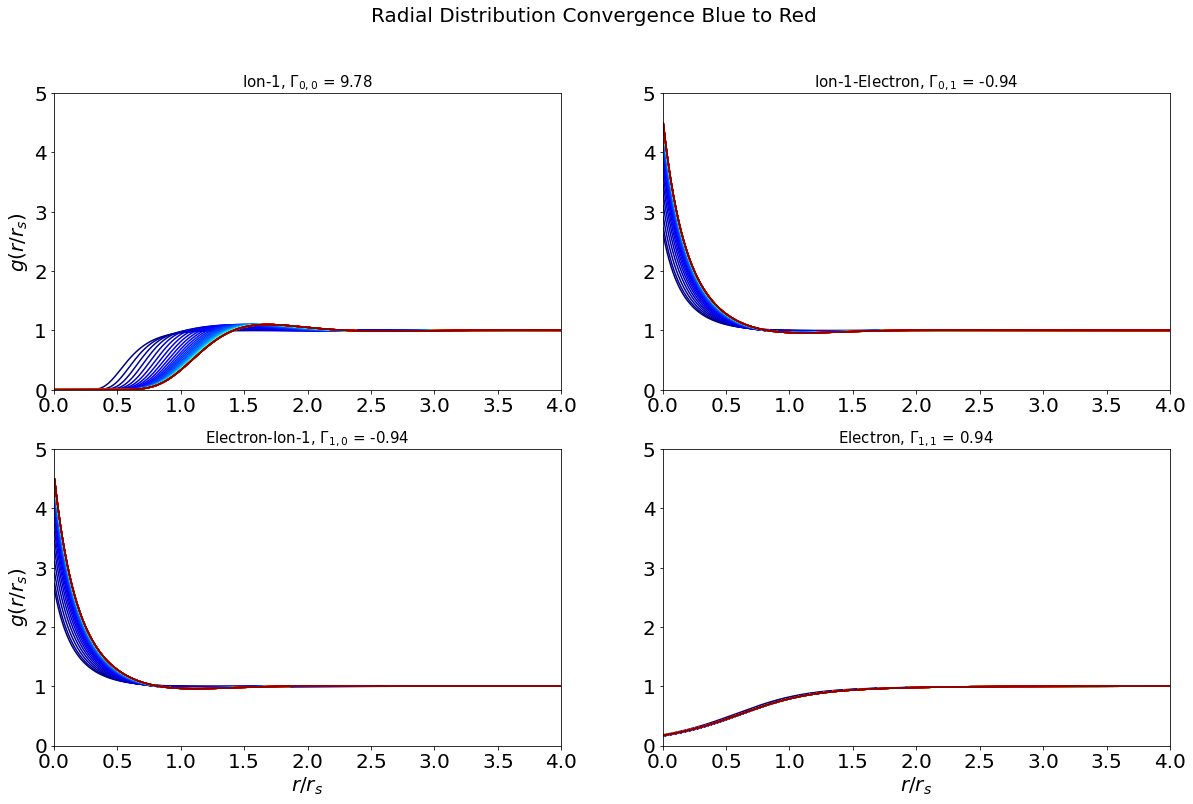

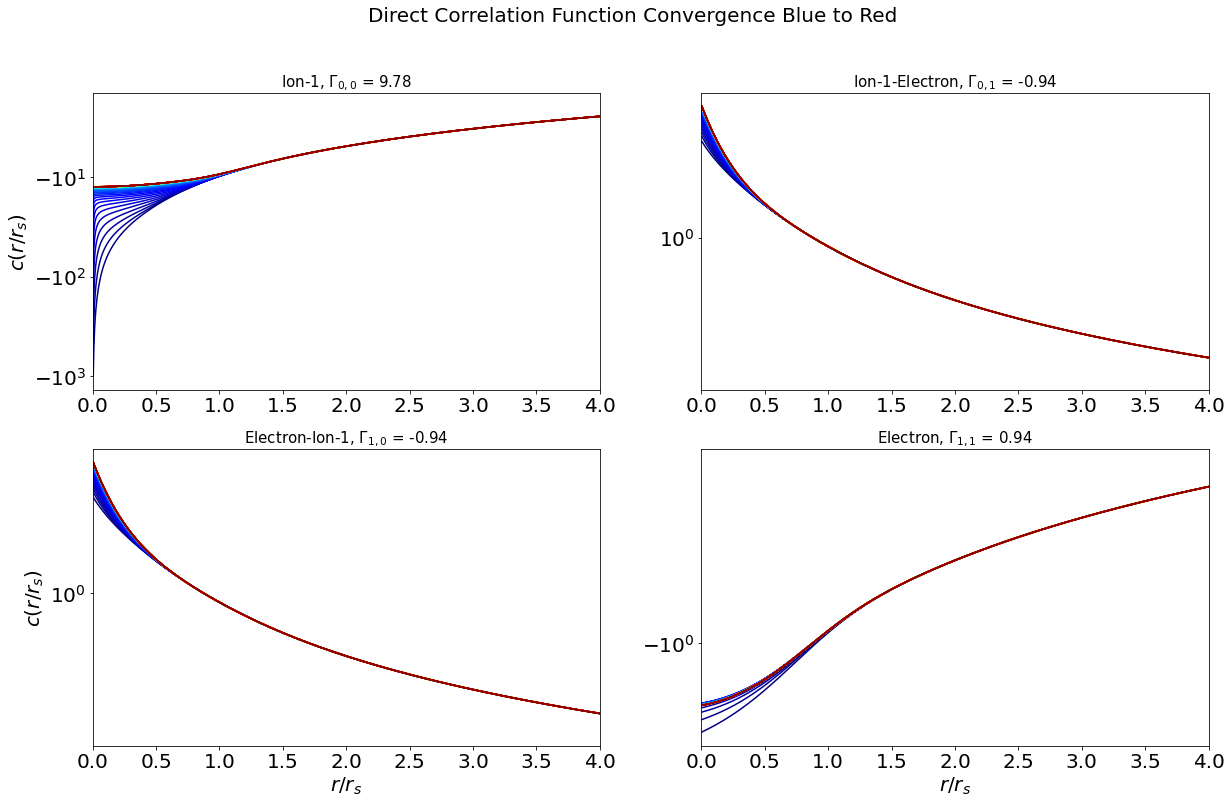

In [29]:
hydrogen.plot_species_convergence_g(n_slices= int(len(hydrogen.h_list)/1)  )
hydrogen.plot_species_convergence_c(n_slices= int(len(hydrogen.h_list)/1)  )

In [30]:
hydrogen_one_species,_ = run_hnc_one_species(ni, Te, Z, A, Zstar )

Λee = 0.465
Λei = 0.329
Γii=9.778, Γie=-0.944, Γee=0.944 
r_i=1.391
r_e=1.391
θ  =7.73e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.00622788] True Optimization terminated successfully.
0: Err in c_r: 3.72e+01, OZ: 1.24e-01, HNC: 1.69e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.00150465] True Optimization terminated successfully.
1: Err in c_r: 1.91e+01, OZ: 1.14e-01, HNC: 1.22e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
2: Err in c_r: 9.93e+00, OZ: 1.05e-01, HNC: 1.04e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.00211755] True Optimization terminated successfully.
3: Err in c_r: 5.22e+00, OZ: 9.06e-02, HNC: 9.42e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.00179066] True Optimization terminated successfully.
4: Err in c_r: 2.77e+00, OZ: 8.08e-02, HNC: 9.05e-03
 HNC min: [0.5] True Optimi

 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
51: Err in c_r: 3.07e-04, OZ: 1.36e-04, HNC: 1.82e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
52: Err in c_r: 2.66e-04, OZ: 1.17e-04, HNC: 1.58e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
53: Err in c_r: 2.30e-04, OZ: 1.02e-04, HNC: 1.37e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
54: Err in c_r: 1.99e-04, OZ: 8.80e-05, HNC: 1.18e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
55: Err in c_r: 1.72e-04, OZ: 7.62e-05, HNC: 1.02e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
56: Err in c_r: 1.49e-04, OZ

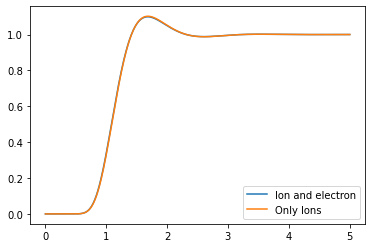

In [31]:
fig, ax = plt.subplots()

ax.plot(hydrogen.r_array, hydrogen.h_r_matrix[0,0]+1, label='Ion and electron')
ax.plot(hydrogen.r_array, hydrogen_one_species.h_r_matrix[0,0]+1, label="Only Ions")
ax.legend()



## Aluminum

In [5]:
ni = 6.03e22 # per cc
Te = 1*eV 
Ti   = 1*eV 
Z, A = 13,27
Zstar= 3
aluminum_i_one_species,_ = run_hnc_one_ion(ni, Te, Z, A, Zstar, num_iterations=1e3 )
aluminum_e_one_species,_ = run_hnc_one_electron(Zstar*ni, Te, 1, m_e/m_p, 1, num_iterations=1e3 )


Λee = 0.313
Λei = 0.222
Γii=81.917, Γie=-2.769, Γee=0.923 
r_i=2.989
r_e=2.073
θ  =8.57e-02
2.9407522127247164e+28
2.9388407234911125e+28
2.93693252989636e+28
2.9350276242627655e+28
2.9312276462901377e+28
2.927440728639509e+28
2.9199058325082e+28
2.912422456108214e+28
2.8976083736962354e+28
2.8829947629705387e+28
2.854354543388284e+28
2.826473853524797e+28
2.7728859768297915e+28
2.7220332696571606e+28
2.6278306987376388e+28
2.542612345189768e+28
2.3951144375765506e+28
2.2730116715621052e+28
2.087503455927994e+28
1.9793279291651397e+28
1.9793279291651397e+28
1.9793279291651397e+28
 HNC min: [0.5] True Optimization terminated successfully.
3.995584647599211e+27
3.695057562360686e+27
4.32130710759217e+27
4.6743959271005405e+27
5.472332948792672e+27
6.410923189723747e+27
8.816913055916027e+27
1.2159253943209806e+28
1.9793279291651397e+28
1.9793279291651397e+28
1.9793279291651397e+28
1.9793279291651397e+28
 OZ min:  [0.] True Optimization terminated successfully.
0: Err in c_r: 1.79e+02, OZ

6.08130774851265e+26
6.0790345604214466e+26
6.082444665634885e+26
6.0835817981965334e+26
6.0818761801464016e+26
6.08130774851265e+26
6.082160416158385e+26
6.081591957598012e+26
6.0820182964693966e+26
6.081734067189288e+26
6.0819472378870964e+26
6.0820182964693966e+26
6.0819117089115474e+26
6.0818761801464016e+26
6.0819294733731075e+26
6.0819472378870964e+26
6.0819205911357826e+26
6.081938355623498e+26
6.081925032252763e+26
 OZ min:  [0.00264347] True Optimization terminated successfully.
7: Err in c_r: 7.05e+00, OZ: 2.62e-01, HNC: 8.87e-02
6.008472049554071e+26
6.0048369366939206e+26
6.001205366323543e+26
5.997577334062551e+26
5.990331866380279e+26
5.983100498732541e+26
5.9686799243934655e+26
5.954315333762242e+26
5.925753002545693e+26
5.8974113188879445e+26
5.84138127564754e+26
5.786208214575209e+26
5.6783670167357465e+26
5.5737594129231335e+26
5.3737602336787367e+26
5.1852941867382115e+26
4.8396828240166026e+26
4.5310409832755995e+26
4.005657093141267e+26
3.6440971734839566e+26
3.644

1.3730424172340224e+25
1.3702994923157053e+25
1.3675638279212346e+25
1.3621141873318642e+25
1.3566933095770641e+25
1.3459371058041241e+25
1.3352937564914384e+25
1.3143398866277383e+25
1.2938204376406234e+25
1.2540413606837032e+25
1.215872716060514e+25
1.144054706222225e+25
1.0777848635817203e+25
9.59867583697021e+24
8.745661830610302e+24
8.745661830610302e+24
8.745661830610302e+24
 HNC min: [0.5] True Optimization terminated successfully.
4.6637613258164057e+24
4.5200906657712597e+24
4.812066113178911e+24
4.965156554949222e+24
5.286325769016477e+24
5.628584615202309e+24
6.382083289475722e+24
7.238063431297494e+24
8.745661830610302e+24
8.745661830610302e+24
8.745661830610302e+24
8.745661830610302e+24
 OZ min:  [0.] True Optimization terminated successfully.
14: Err in c_r: 2.12e+00, OZ: 2.62e-01, HNC: 6.61e-02
8.654126415106778e+24
8.649581111214122e+24
8.645038787131517e+24
8.640499440548162e+24
8.631429670643232e+24
8.622371783049206e+24
8.604291581154737e+24
8.586258687908919e+24
8.5

1.9453393418118255e+23
 HNC min: [0.5] True Optimization terminated successfully.
1.2390171728758566e+23
1.2114737411811173e+23
1.2671959168768938e+23
1.2960248239056732e+23
1.3556942957277779e+23
1.4181515765441896e+23
1.5519640065461923e+23
1.6985961760759046e+23
1.9453393418118255e+23
1.9453393418118255e+23
1.9453393418118255e+23
1.9453393418118255e+23
 OZ min:  [0.] True Optimization terminated successfully.
23: Err in c_r: 1.02e+00, OZ: 2.47e-01, HNC: 3.89e-02
1.9319398650608332e+23
1.9312727727995892e+23
1.9306059540217377e+23
1.929939408597888e+23
1.928607137294474e+23
1.9272759578548824e+23
1.924616870434615e+23
1.921962138082908e+23
1.9166657056551674e+23
1.911386594883703e+23
1.900880076931756e+23
1.8904420642007926e+23
1.8697694959550025e+23
1.8493648160217257e+23
1.8093431612048765e+23
1.770345836316998e+23
1.695304205792878e+23
1.6240096498520884e+23
1.491813202281332e+23
1.3914657918261736e+23
1.3914657918261736e+23
1.3914657918261736e+23
 HNC min: [0.5] True Optimization

1.4949481613570878e+22
1.4945968291061015e+22
1.4942455933764979e+22
1.4938944541380105e+22
1.4931924650132897e+22
1.4924908614898128e+22
1.4910888102790676e+22
1.4896882985724606e+22
1.4868918859514056e+22
1.4841016082126814e+22
1.4785393959382265e+22
1.4730015392823176e+22
1.4619984063118688e+22
1.451091242923477e+22
1.4295610120225616e+22
1.4084033243922605e+22
1.3671763012395106e+22
1.327353187521224e+22
1.2517027832209661e+22
1.192579211619947e+22
1.192579211619947e+22
1.192579211619947e+22
 HNC min: [0.5] True Optimization terminated successfully.
8.391284837133887e+21
8.24544794393895e+21
8.539736373835805e+21
8.690850020430626e+21
9.001257883824115e+21
9.322905887041594e+21
1.0001586415696553e+22
1.0730376226786953e+22
1.192579211619947e+22
1.192579211619947e+22
1.192579211619947e+22
1.192579211619947e+22
 OZ min:  [0.] True Optimization terminated successfully.
33: Err in c_r: 5.78e-01, OZ: 1.99e-01, HNC: 1.87e-02
1.1872034758472833e+22
1.18693543282768e+22
1.1866674604869474e

2.1298191911101792e+21
2.1298191911101792e+21
2.1298191911101792e+21
 HNC min: [0.5] True Optimization terminated successfully.
1.5793863939228272e+21
1.5559946980610684e+21
1.6031341353296858e+21
1.6272434037990537e+21
1.6765688757642283e+21
1.7274083919431852e+21
1.8338190812294228e+21
1.9468695564205385e+21
2.1298191911101792e+21
2.1298191911101792e+21
2.1298191911101792e+21
2.1298191911101792e+21
 OZ min:  [0.] True Optimization terminated successfully.
42: Err in c_r: 3.81e-01, OZ: 1.62e-01, HNC: 1.11e-02
2.1230012460884343e+21
2.1226610156344037e+21
2.122320848586563e+21
2.1219807449316091e+21
2.1213007277467356e+21
2.1206209639727814e+21
2.1192621962298943e+21
2.1179044408481447e+21
2.115191963752473e+21
2.1124835258624406e+21
2.1070787404690455e+21
2.1016900303316693e+21
2.0909606194734118e+21
2.0802948625602042e+21
2.059152603356485e+21
2.0382598693450492e+21
1.9972096883211436e+21
1.9571182215570286e+21
1.879710766850998e+21
1.8180113227024672e+21
1.8180113227024672e+21
1.818

5.686337702542672e+20
6.15616861838177e+20
6.15616861838177e+20
6.15616861838177e+20
6.15616861838177e+20
 OZ min:  [0.] True Optimization terminated successfully.
51: Err in c_r: 2.64e-01, OZ: 1.30e-01, HNC: 7.14e-03
6.141844132369705e+20
6.141128926354511e+20
6.140413817210367e+20
6.139698804922559e+20
6.138269070856727e+20
6.13683972403884e+20
6.133982191674276e+20
6.131126206884347e+20
6.125418876252729e+20
6.119717724599339e+20
6.108333928097926e+20
6.096974757221391e+20
6.074330052500542e+20
6.051783132330171e+20
6.006980745782215e+20
5.962563822797094e+20
5.8748714658794734e+20
5.788676647120539e+20
5.620665014745421e+20
5.48519120600512e+20
5.48519120600512e+20
5.48519120600512e+20
 HNC min: [0.5] True Optimization terminated successfully.
4.2240930402416355e+20
4.169355710561709e+20
4.2795568966710074e+20
4.335757019891493e+20
4.4504056875876234e+20
4.5681196318741384e+20
4.8130767459998754e+20
5.0713180939680966e+20
5.48519120600512e+20
5.48519120600512e+20
5.48519120600512e+

2.4702515653038073e+20
2.470039124035525e+20
2.4696143056389836e+20
2.4691895727463743e+20
2.468340363396395e+20
2.4674914958319216e+20
2.4657947854458726e+20
2.4640994403613108e+20
2.4607128411946533e+20
2.45733168854003e+20
2.4505856836938806e+20
2.4438613478655938e+20
2.4304773729393728e+20
2.4171791461080747e+20
2.390837489889661e+20
2.3648315325304203e+20
2.3138076981790255e+20
2.2723363196211082e+20
2.2723363196211082e+20
2.2723363196211082e+20
 HNC min: [0.5] True Optimization terminated successfully.
1.7912906920099722e+20
1.7701368220641287e+20
1.8126997944071592e+20
1.8343672356036067e+20
1.8784897507863727e+20
1.9236838589756778e+20
2.0173925188996003e+20
2.1157111251858666e+20
2.2723363196211082e+20
2.2723363196211082e+20
2.2723363196211082e+20
2.2723363196211082e+20
 OZ min:  [0.] True Optimization terminated successfully.
61: Err in c_r: 1.82e-01, OZ: 1.01e-01, HNC: 4.68e-03
2.2685576727641512e+20
2.2683689337475236e+20
2.2681802131282683e+20
2.267991510904352e+20
2.26761

1.2554849031725197e+20
1.2548426128915336e+20
1.2542007111291961e+20
1.2529180721148443e+20
1.2516369840401675e+20
1.24907945236774e+20
1.2465280994578776e+20
1.24144386355014e+20
1.236384144044007e+20
1.2263377289525818e+20
1.2163878111663014e+20
1.1967733551856937e+20
1.1807387251443337e+20
1.1807387251443337e+20
1.1807387251443337e+20
 HNC min: [0.5] True Optimization terminated successfully.
9.469949472504957e+19
9.366166662597406e+19
9.57489181955185e+19
9.68100675513357e+19
9.896807338560045e+19
1.0117458621992817e+20
1.0573755182092906e+20
1.1050805609607352e+20
1.1807387251443337e+20
1.1807387251443337e+20
1.1807387251443337e+20
1.1807387251443337e+20
 OZ min:  [0.] True Optimization terminated successfully.
70: Err in c_r: 1.34e-01, OZ: 8.00e-02, HNC: 3.31e-03
1.1792768950248689e+20
1.1792038597631522e+20
1.1791308298548181e+20
1.1790578052994562e+20
1.1789117722458282e+20
1.1787657605987801e+20
1.1784738015105078e+20
1.1781819280066804e+20
1.1775984376407617e+20
1.17701528927

7.237786857447063e+19
 HNC min: [0.5] True Optimization terminated successfully.
5.883307122960324e+19
5.822717379173684e+19
5.944531815916011e+19
6.0063981534138925e+19
6.1320828992151134e+19
6.260416356735478e+19
6.525255280162978e+19
6.801378801079147e+19
7.237786857447063e+19
7.237786857447063e+19
7.237786857447063e+19
7.237786857447063e+19
 OZ min:  [0.] True Optimization terminated successfully.
79: Err in c_r: 9.94e-02, OZ: 6.28e-02, HNC: 2.41e-03
7.2310658229998e+19
7.2307299662628815e+19
7.230394128087642e+19
7.2300583084729524e+19
7.229386724920484e+19
7.228715215596473e+19
7.227372419597006e+19
7.2260299204015325e+19
7.223345812130315e+19
7.220662890198751e+19
7.215300603019689e+19
7.20994305419792e+19
7.199242152985193e+19
7.1885601493274345e+19
7.1672526861373374e+19
7.146020368333111e+19
7.103779989950121e+19
7.0618366687286075e+19
6.978831914495235e+19
6.910654674966327e+19
6.910654674966327e+19
6.910654674966327e+19
 HNC min: [0.5] True Optimization terminated successfu

5.005734026925861e+19
 OZ min:  [0.] True Optimization terminated successfully.
88: Err in c_r: 7.45e-02, OZ: 4.91e-02, HNC: 1.80e-03
5.002219550342398e+19
5.002043903675466e+19
5.001868264354782e+19
5.001692632380055e+19
5.001341390467095e+19
5.00099017793368e+19
5.0002878409951126e+19
4.999585621542324e+19
4.998181535006996e+19
4.9967779181530866e+19
4.993972092791269e+19
4.9911681440609526e+19
4.9855658709169275e+19
4.979971087576375e+19
4.968803945815734e+19
4.957666629977287e+19
4.935481122276574e+19
4.9134138597148434e+19
4.869631273402877e+19
4.833557151419523e+19
4.833557151419523e+19
4.833557151419523e+19
 HNC min: [0.5] True Optimization terminated successfully.
3.977075163560469e+19
3.9385023797338464e+19
4.0160279093972976e+19
4.0553643786710655e+19
4.135203720572321e+19
4.216624035269476e+19
4.38433406140882e+19
4.558753777262831e+19
4.833557151419523e+19
4.833557151419523e+19
4.833557151419523e+19
4.833557151419523e+19
 OZ min:  [0.] True Optimization terminated successfu

3.779716141854162e+19
3.778908725684906e+19
3.7772945094180495e+19
3.7756811141946745e+19
3.772456785030559e+19
3.769235734499696e+19
3.762803454587825e+19
3.756384245004474e+19
3.743584919360957e+19
3.730837523354917e+19
3.705497589053081e+19
3.684570243142364e+19
3.684570243142364e+19
3.684570243142364e+19
 HNC min: [0.5] True Optimization terminated successfully.
3.0609020117646406e+19
3.032664376495571e+19
3.0894037988501426e+19
3.118172218345411e+19
3.176518993993505e+19
3.235962654778398e+19
3.3582238262135587e+19
3.4851260850444366e+19
3.684570243142364e+19
3.684570243142364e+19
3.684570243142364e+19
3.684570243142364e+19
 OZ min:  [0.] True Optimization terminated successfully.
98: Err in c_r: 5.43e-02, OZ: 3.72e-02, HNC: 1.31e-03
3.682660834971166e+19
3.68256539549321e+19
3.6824699589602796e+19
3.6823745253723197e+19
3.682183667030721e+19
3.6819928204676796e+19
3.6816111626739e+19
3.6812295519846638e+19
3.6804664718937797e+19
3.6797035801436955e+19
3.67817836146015e+19
3.67665

2.995412057185e+19
2.995412057185e+19
2.995412057185e+19
 HNC min: [0.5] True Optimization terminated successfully.
2.511008676037721e+19
2.48896636295722e+19
2.533246888661801e+19
2.5556827466967958e+19
2.601154460558977e+19
2.647438098882798e+19
2.742499559558022e+19
2.8409865862253703e+19
2.995412057185e+19
2.995412057185e+19
2.995412057185e+19
2.995412057185e+19
 OZ min:  [0.] True Optimization terminated successfully.
107: Err in c_r: 4.11e-02, OZ: 2.90e-02, HNC: 9.89e-04
2.994225999516073e+19
2.9941667113141686e+19
2.994107424510203e+19
2.9940481391041466e+19
2.993929572485768e+19
2.993811011458667e+19
2.993573906177251e+19
2.9933368232576025e+19
2.992862724494266e+19
2.9923887151501267e+19
2.991440964645131e+19
2.99049357159427e+19
2.9885998572613853e+19
2.986707570965471e+19
2.9829272777457148e+19
2.9791526824681005e+19
2.9716205479558885e+19
2.964111092030709e+19
2.949159915692408e+19
2.9367885489359495e+19
2.9367885489359495e+19
2.9367885489359495e+19
 HNC min: [0.5] True Opt

2.5563693772804063e+19
2.5563693772804063e+19
2.5563693772804063e+19
2.5563693772804063e+19
 OZ min:  [0.] True Optimization terminated successfully.
116: Err in c_r: 3.12e-02, OZ: 2.25e-02, HNC: 7.50e-04
2.5555937167574876e+19
2.5555549410945745e+19
2.5555161661327745e+19
2.555477391872124e+19
2.5553998454542107e+19
2.5553223018406543e+19
2.555167223026337e+19
2.5550121554282754e+19
2.554702053877375e+19
2.554391997180854e+19
2.5537720183224627e+19
2.5531522187963e+19
2.551913157513155e+19
2.550674812876956e+19
2.5482002717291217e+19
2.5457285917232312e+19
2.540793800643561e+19
2.535870410700183e+19
2.526057718865147e+19
2.517927756893559e+19
2.517927756893559e+19
2.517927756893559e+19
 HNC min: [0.5] True Optimization terminated successfully.
2.132033957899109e+19
2.1143767276178678e+19
2.1498389847948235e+19
2.1677930473129095e+19
2.204153287306604e+19
2.2411247994026594e+19
2.3169429815297065e+19
2.3953320285799227e+19
2.517927756893559e+19
2.517927756893559e+19
2.517927756893559e+

2.262805184732875e+19
2.2626997025516274e+19
2.2624887557901025e+19
2.262277832494198e+19
2.261856056287879e+19
2.2614343739097907e+19
2.2605912905472713e+19
2.2597485822243287e+19
2.2580642899685364e+19
2.2563814956861256e+19
2.2530203952233865e+19
2.2496652692155146e+19
2.242972894203407e+19
2.2374227409828016e+19
2.2374227409828016e+19
2.2374227409828016e+19
 HNC min: [0.5] True Optimization terminated successfully.
1.912502371593534e+19
1.8975577371514376e+19
1.9275648456401015e+19
1.94274608884077e+19
1.9734686376051007e+19
2.004677601903504e+19
2.0685857153563316e+19
2.1345335368527057e+19
2.2374227409828016e+19
2.2374227409828016e+19
2.2374227409828016e+19
2.2374227409828016e+19
 OZ min:  [0.] True Optimization terminated successfully.
126: Err in c_r: 2.31e-02, OZ: 1.70e-02, HNC: 5.53e-04
2.236916263840249e+19
2.2368909435748106e+19
2.236865623651388e+19
2.2368403040699933e+19
2.2367896659332563e+19
2.236739029164538e+19
2.2366377597310415e+19
2.2365364957691703e+19
2.236333984

1.751344691170057e+19
1.777235819971962e+19
1.7903245760682314e+19
1.8167919928841509e+19
1.843650704708939e+19
1.8985652194715816e+19
1.955115392347324e+19
2.0431143839150735e+19
2.0431143839150735e+19
2.0431143839150735e+19
2.0431143839150735e+19
 OZ min:  [0.] True Optimization terminated successfully.
135: Err in c_r: 1.77e-02, OZ: 1.32e-02, HNC: 4.22e-04
2.04275832930078e+19
2.04274052851656e+19
2.042722727917683e+19
2.0427049275041747e+19
2.0426693272332276e+19
2.0426337277037494e+19
2.0425625308689404e+19
2.0424913369995977e+19
2.042348958156871e+19
2.042206591174472e+19
2.0419218927863923e+19
2.041637241826724e+19
2.0410680821583725e+19
2.0404991121004974e+19
2.0393617405412557e+19
2.0382251265990164e+19
2.035954169367643e+19
2.033686236015e+19
2.02915942341483e+19
2.025402153966898e+19
2.025402153966898e+19
2.025402153966898e+19
 HNC min: [0.5] True Optimization terminated successfully.
1.7510196765361662e+19
1.7383210429411475e+19
1.7638110683046492e+19
1.7766958951907527e+19

1.9049742104695173e+19
 OZ min:  [0.] True Optimization terminated successfully.
144: Err in c_r: 1.36e-02, OZ: 1.02e-02, HNC: 3.23e-04
1.9047181964187046e+19
1.904705396796885e+19
1.904692597277984e+19
1.904679797862011e+19
1.9046541993388036e+19
1.904628601227257e+19
1.9045774062391243e+19
1.9045262128975577e+19
1.9044238311538905e+19
1.9043214559958e+19
1.90411672543451e+19
1.9039120212100014e+19
1.9035026917565415e+19
1.9030934676059804e+19
1.902275335095759e+19
1.901457623443889e+19
1.899823461773998e+19
1.8981909807154192e+19
1.8949310529199067e+19
1.892223798137135e+19
1.892223798137135e+19
1.892223798137135e+19
 HNC min: [0.5] True Optimization terminated successfully.
1.654364127536267e+19
1.6432883453961644e+19
1.6655144687270928e+19
1.6767398697944746e+19
1.6994178716480664e+19
1.7224022071616465e+19
1.7693064497804263e+19
1.8174862978881448e+19
1.892223798137135e+19
1.892223798137135e+19
1.892223798137135e+19
1.892223798137135e+19
 OZ min:  [0.] True Optimization terminated

1.8043789732839606e+19
1.8043040658637746e+19
1.80415426219935e+19
1.804004473434855e+19
1.803704940599134e+19
1.803405467343801e+19
1.8028066995227011e+19
1.8022081698687033e+19
1.8010118246506555e+19
1.7998164308676016e+19
1.7974284943221008e+19
1.795444549827422e+19
1.795444549827422e+19
1.795444549827422e+19
 HNC min: [0.5] True Optimization terminated successfully.
1.589343980838862e+19
1.5796824120906506e+19
1.5990644985087425e+19
1.608844323503243e+19
1.6285833399307518e+19
1.6485639409394907e+19
1.6892617169838074e+19
1.730961652213324e+19
1.795444549827422e+19
1.795444549827422e+19
1.795444549827422e+19
1.795444549827422e+19
 OZ min:  [0.] True Optimization terminated successfully.
154: Err in c_r: 1.02e-02, OZ: 7.72e-03, HNC: 2.41e-04
1.7952634681590548e+19
1.7952544146500356e+19
1.7952453611957064e+19
1.7952363077961124e+19
1.7952182011609788e+19
1.7952000947446587e+19
1.7951638825684017e+19
1.7951276712673212e+19
1.7950552512905996e+19
1.7949828348143067e+19
1.7948380123622

1.7240536435952417e+19
 HNC min: [0.5] True Optimization terminated successfully.
1.5472282584257608e+19
1.5388776146627647e+19
1.5556240525085389e+19
1.5640652397966322e+19
1.5810847720234316e+19
1.598288824257386e+19
1.6332584710040183e+19
1.6689903589991944e+19
1.7240536435952417e+19
1.7240536435952417e+19
1.7240536435952417e+19
1.7240536435952417e+19
 OZ min:  [0.] True Optimization terminated successfully.
163: Err in c_r: 7.88e-03, OZ: 5.99e-03, HNC: 1.86e-04
1.723919190587736e+19
1.7239124682674813e+19
1.7239057459786449e+19
1.7238990237212467e+19
1.7238855793007819e+19
1.7238721350060458e+19
1.7238452467938308e+19
1.7238183590846167e+19
1.72376458517506e+19
1.723710813277276e+19
1.7236032755167785e+19
1.723495745802476e+19
1.7232807105097644e+19
1.723065707393979e+19
1.7226357976722174e+19
1.7222060165954464e+19
1.7213468402099005e+19
1.720488177903615e+19
1.7187723941951627e+19
1.7173463728269203e+19
1.7173463728269203e+19
1.7173463728269203e+19
 HNC min: [0.5] True Optimizati

1.6706664214920176e+19
1.6706613795135025e+19
1.6706512956112167e+19
1.6706412117820199e+19
1.6706210443428061e+19
1.670600877195756e+19
1.6705605437783638e+19
1.6705202115297937e+19
1.670439550538945e+19
1.670358894222955e+19
1.6701975956143352e+19
1.6700363157015499e+19
1.6697138119541746e+19
1.6693913829620382e+19
1.6687467491684178e+19
1.6681024141705912e+19
1.6668146399622076e+19
1.6657440811707668e+19
1.6657440811707668e+19
1.6657440811707668e+19
 HNC min: [0.5] True Optimization terminated successfully.
1.520371045925896e+19
1.5134433989835074e+19
1.527330247231766e+19
1.5343211456083511e+19
1.548398607598017e+19
1.5626045863740457e+19
1.5914067640536574e+19
1.6207371231701187e+19
1.6657440811707668e+19
1.6657440811707668e+19
1.6657440811707668e+19
1.6657440811707668e+19
 OZ min:  [0.] True Optimization terminated successfully.
173: Err in c_r: 5.92e-03, OZ: 4.52e-03, HNC: 1.39e-04
1.6656463583904051e+19
1.6656414724320434e+19
1.6656365864908763e+19
1.6656317005669173e+19
1.6656

1.6304672451696273e+19
1.63040626994531e+19
1.6303452974599242e+19
1.6302233607053814e+19
1.6301014349049463e+19
1.6298576161621334e+19
1.6296138412229749e+19
1.629126422721487e+19
1.6286391793323559e+19
1.6276652176187105e+19
1.6268553842872375e+19
1.6268553842872375e+19
1.6268553842872375e+19
 HNC min: [0.5] True Optimization terminated successfully.
1.5099429014472993e+19
1.5043217320635242e+19
1.5155849527884956e+19
1.521247962928466e+19
1.5326371683618572e+19
1.5441111380596525e+19
1.5673158740217178e+19
1.5908672238543333e+19
1.6268553842872375e+19
1.6268553842872375e+19
1.6268553842872375e+19
1.6268553842872375e+19
 OZ min:  [0.] True Optimization terminated successfully.
182: Err in c_r: 4.58e-03, OZ: 3.51e-03, HNC: 1.08e-04
1.6267814587628165e+19
1.62677776259251e+19
1.6267740664323035e+19
1.6267703702821765e+19
1.6267629780121831e+19
1.6267555857825667e+19
1.6267408014443362e+19
1.6267260172675277e+19
1.626696449398042e+19
1.6266668821741429e+19
1.626607749662965e+19
1.626548

1.5996339268424829e+19
1.5994485087524653e+19
1.599077750056987e+19
1.5987070946482326e+19
1.5979660935664691e+19
1.597349872117542e+19
1.597349872117542e+19
1.597349872117542e+19
 HNC min: [0.5] True Optimization terminated successfully.
1.5097669765657717e+19
1.5055154455705831e+19
1.5140304490171566e+19
1.5183058960314677e+19
1.5268928466213945e+19
1.5355280949755234e+19
1.5529445587265323e+19
1.5705574492662143e+19
1.597349872117542e+19
1.597349872117542e+19
1.597349872117542e+19
1.597349872117542e+19
 OZ min:  [0.] True Optimization terminated successfully.
191: Err in c_r: 3.55e-03, OZ: 2.72e-03, HNC: 8.32e-05
1.597293619048191e+19
1.597290806457234e+19
1.5972879938721964e+19
1.597285181293141e+19
1.5972795561528676e+19
1.5972739310363994e+19
1.5972626808749023e+19
1.5972514308086227e+19
1.597228930961786e+19
1.5972064314958508e+19
1.5971614337067035e+19
1.597116437441146e+19
1.5970264494805586e+19
1.5969364676136581e+19
1.5967565221591372e+19
1.596576601073939e+19
1.596216831997

1.5748464648876829e+19
1.5748464648876829e+19
1.5748464648876829e+19
 HNC min: [0.5] True Optimization terminated successfully.
1.5179259074120292e+19
1.5151346612928618e+19
1.5207223113080506e+19
1.5235238823112907e+19
1.5291425630379033e+19
1.5347820245432648e+19
1.546123590933302e+19
1.557549186049934e+19
1.5748464648876829e+19
1.5748464648876829e+19
1.5748464648876829e+19
1.5748464648876829e+19
 OZ min:  [0.] True Optimization terminated successfully.
200: Err in c_r: 2.75e-03, OZ: 2.11e-03, HNC: 6.44e-05
1.5748034641206626e+19
1.5748013141193722e+19
1.574799164121608e+19
1.5747970141273717e+19
1.5747927141495017e+19
1.5747884141857319e+19
1.574779814300556e+19
1.5747712144718236e+19
1.5747540149837922e+19
1.5747368157216227e+19
1.5747024178748735e+19
1.5746680209315092e+19
1.5745992297549304e+19
1.5745304421916908e+19
1.574392877904411e+19
1.5742553280679733e+19
1.5739802717412086e+19
1.5737052731982397e+19
1.5731554494112348e+19
1.5726981548834093e+19
1.5726981548834093e+19
1.572

1.557613951553801e+19
1.557613951553801e+19
1.557613951553801e+19
1.557613951553801e+19
 OZ min:  [0.] True Optimization terminated successfully.
209: Err in c_r: 2.13e-03, OZ: 1.64e-03, HNC: 4.99e-05
1.557580964804414e+19
1.5575793154890164e+19
1.5575776661757028e+19
1.557576016864491e+19
1.5575727182483644e+19
1.5575694196406524e+19
1.5575628224504035e+19
1.5575562252938068e+19
1.5575430310813661e+19
1.5575298370033773e+19
1.5575034492506733e+19
1.5574770620356688e+19
1.5574242892187628e+19
1.5573715185525561e+19
1.5572659836717832e+19
1.5571604573926326e+19
1.5569494306361225e+19
1.5567384382769281e+19
1.5563165567262888e+19
1.5559656429032002e+19
1.5559656429032002e+19
1.5559656429032002e+19
 HNC min: [0.5] True Optimization terminated successfully.
1.5350219567041653e+19
1.533983542402411e+19
1.5360612028735388e+19
1.5371012814449932e+19
1.5391839379295443e+19
1.5412699304241033e+19
1.5454519404702947e+19
1.54964734555953e+19
1.5559656429032002e+19
1.5559656429032002e+19
1.5559656

1.544349699576255e+19
1.5443484308822233e+19
1.5443471621894554e+19
1.5443446248076857e+19
1.5443420874309233e+19
1.5443370126924368e+19
1.5443319379740506e+19
1.5443217885974075e+19
1.5443116393010196e+19
1.5442913409489957e+19
1.544271042917923e+19
1.5442304478187377e+19
1.5441898540034136e+19
1.5441086702241729e+19
1.5440274915798522e+19
1.5438651496945035e+19
1.5437028283445619e+19
1.543378247239762e+19
1.5431082481972507e+19
1.5431082481972507e+19
1.5431082481972507e+19
 HNC min: [0.5] True Optimization terminated successfully.
1.5564054456879397e+19
1.5570759176338332e+19
1.555735512156739e+19
1.5550661164186948e+19
1.5537289358364813e+19
1.5523938989722049e+19
1.5497302365350552e+19
1.5470750894098962e+19
1.5431082481972507e+19
1.5431082481972507e+19
1.5431082481972507e+19
1.5431082481972507e+19
 OZ min:  [0.] True Optimization terminated successfully.
219: Err in c_r: 1.61e-03, OZ: 1.24e-03, HNC: 3.76e-05
1.5430835996037487e+19
1.5430823671865184e+19
1.5430811347704568e+19
1.54

1.5341583404000442e+19
1.5341563844351986e+19
1.5341524725144805e+19
1.5341485606057769e+19
1.5341407368243745e+19
1.5341329130909878e+19
1.5341172657682426e+19
1.534101618637548e+19
1.5340703249522815e+19
1.5340390320351537e+19
1.5339764485052631e+19
1.5339138680477155e+19
1.5337887163489726e+19
1.5336635769376109e+19
1.5334133349719224e+19
1.533205163284466e+19
1.533205163284466e+19
1.533205163284466e+19
 HNC min: [0.5] True Optimization terminated successfully.
1.582510882296099e+19
1.5850214204839264e+19
1.5800047057443142e+19
1.5775028825605851e+19
1.5725122633076142e+19
1.5675389587212503e+19
1.557644031588857e+19
1.547817579836994e+19
1.533205163284466e+19
1.533205163284466e+19
1.533205163284466e+19
1.533205163284466e+19
 OZ min:  [0.] True Optimization terminated successfully.
228: Err in c_r: 1.25e-03, OZ: 9.62e-04, HNC: 2.91e-05
1.5331861588280426e+19
1.5331852086126625e+19
1.5331842583980001e+19
1.5331833081840364e+19
1.5331814077582455e+19
1.5331795073352593e+19
1.533175706

1.52572433425944e+19
1.5255635744077222e+19
1.5255635744077222e+19
1.5255635744077222e+19
 HNC min: [0.5] True Optimization terminated successfully.
1.6125505856553736e+19
1.6170334557638668e+19
1.608080675104218e+19
1.6036236851378663e+19
1.5947483116748857e+19
1.5859241559025144e+19
1.5684282695622812e+19
1.5511335893875042e+19
1.5255635744077222e+19
1.5255635744077222e+19
1.5255635744077222e+19
1.5255635744077222e+19
 OZ min:  [0.] True Optimization terminated successfully.
237: Err in c_r: 9.68e-04, OZ: 7.47e-04, HNC: 2.26e-05
1.525548898181444e+19
1.5255481643746015e+19
1.5255474305681682e+19
1.525546696762162e+19
1.5255452291514356e+19
1.5255437615424e+19
1.5255408263294335e+19
1.525537891123255e+19
1.5255320207313037e+19
1.5255261503665408e+19
1.5255144097185714e+19
1.5255026691793328e+19
1.5254791884271512e+19
1.5254557081099332e+19
1.5254087487804324e+19
1.5253617911907596e+19
1.5252678812306383e+19
1.5251739782290057e+19
1.5249861930990025e+19
1.5248299712114147e+19
1.5248299

1.606904679233054e+19
1.5814650841950032e+19
1.556438645599504e+19
1.5196586524513278e+19
1.5196586524513278e+19
1.5196586524513278e+19
1.5196586524513278e+19
 OZ min:  [0.] True Optimization terminated successfully.
246: Err in c_r: 7.51e-04, OZ: 5.80e-04, HNC: 1.75e-05
1.5196473046121818e+19
1.5196467372229044e+19
1.5196461698338847e+19
1.5196456024451045e+19
1.5196444676683375e+19
1.5196433328925802e+19
1.519641063344122e+19
1.519638793799748e+19
1.519634254723259e+19
1.5196297156630723e+19
1.519620637591659e+19
1.5196115595855258e+19
1.5195934037691011e+19
1.5195752482137752e+19
1.5195389378864398e+19
1.5195026286034788e+19
1.5194300131705154e+19
1.519357401914677e+19
1.5192121919332454e+19
1.5190913854229438e+19
1.5190913854229438e+19
1.5190913854229438e+19
 HNC min: [0.5] True Optimization terminated successfully.
1.6497310850147457e+19
1.6565577159069037e+19
1.6429332897433604e+19
1.6361642054254512e+19
1.622711673731457e+19
1.609372503561729e+19
1.583030345686854e+19
1.55713001

1.5150753076267645e+19
1.515071794559095e+19
1.5150682815012037e+19
1.5150612554148823e+19
1.5150542293677914e+19
1.5150401773912398e+19
1.5150261255716116e+19
1.5149980224030034e+19
1.5149699198619552e+19
1.5149137166624285e+19
1.5148575159729424e+19
1.5147451221235812e+19
1.5146516145796293e+19
1.5146516145796293e+19
1.5146516145796293e+19
 HNC min: [0.5] True Optimization terminated successfully.
1.6860350464619287e+19
1.6951051054023772e+19
1.6770143801571035e+19
1.6680428330023105e+19
1.6502460098823117e+19
1.6326424198206341e+19
1.598006430421454e+19
1.5641180854207332e+19
1.5146516145796293e+19
1.5146516145796293e+19
1.5146516145796293e+19
1.5146516145796293e+19
 OZ min:  [0.] True Optimization terminated successfully.
256: Err in c_r: 5.67e-04, OZ: 4.38e-04, HNC: 1.32e-05
1.5146430779234152e+19
1.5146426510921112e+19
1.5146422242609596e+19
1.5146417974299595e+19
1.5146409437683997e+19
1.514640090107401e+19
1.5146383827871699e+19
1.5146366754692377e+19
1.514633260840331e+19
1.51

1.7132809913609073e+19
1.7019927622683714e+19
1.6796419340868745e+19
1.657588564488384e+19
1.6143582187281267e+19
1.572270302744926e+19
1.5112138373065886e+19
1.5112138373065886e+19
1.5112138373065886e+19
1.5112138373065886e+19
 OZ min:  [0.] True Optimization terminated successfully.
265: Err in c_r: 4.40e-04, OZ: 3.40e-04, HNC: 1.03e-05
1.51120722486164e+19
1.51120689424029e+19
1.5112065636190558e+19
1.5112062329978946e+19
1.511205571755818e+19
1.5112049105141193e+19
1.511203588031735e+19
1.5112022655507524e+19
1.5111996205929697e+19
1.5111969756407597e+19
1.5111916857530761e+19
1.5111863958876555e+19
1.5111758162237151e+19
1.5111652366489336e+19
1.5111440777669235e+19
1.5111229192415513e+19
1.5110806032608125e+19
1.5110382887066978e+19
1.510953663878081e+19
1.5108832577248768e+19
1.5108832577248768e+19
1.5108832577248768e+19
 HNC min: [0.5] True Optimization terminated successfully.
1.7290669553367626e+19
1.740778879438182e+19
1.7174348650443213e+19
1.7058820575829582e+19
1.68301210

1.5085422537504911e+19
1.5085412287837676e+19
1.5085391788528445e+19
1.5085371289252688e+19
1.5085330290801818e+19
1.5085289292485128e+19
1.5085207296254288e+19
1.5085125300559895e+19
1.5084961310780916e+19
1.5084797323148466e+19
1.5084469354322334e+19
1.5084141394081577e+19
1.5083485499354e+19
1.5082939800614859e+19
1.5082939800614859e+19
1.5082939800614859e+19
 HNC min: [0.5] True Optimization terminated successfully.
1.7699984332129905e+19
1.7842278753615327e+19
1.755883663084693e+19
1.741882631615574e+19
1.7142180894942706e+19
1.686997492208117e+19
1.6338594700406495e+19
1.5824124064022952e+19
1.5082939800614859e+19
1.5082939800614859e+19
1.5082939800614859e+19
1.5082939800614859e+19
 OZ min:  [0.] True Optimization terminated successfully.
275: Err in c_r: 3.32e-04, OZ: 2.57e-04, HNC: 7.75e-06
1.5082889981427e+19
1.508288749047292e+19
1.5082884999519136e+19
1.5082882508565955e+19
1.508287752666097e+19
1.5082872544758106e+19
1.5082862580958118e+19
1.5082852617166205e+19
1.508283268

1.8129291343037348e+19
1.8298179853163858e+19
1.7961975033944383e+19
1.7796216169692901e+19
1.7469312447554509e+19
1.7148464894990686e+19
1.6524487982220247e+19
1.5923405848175616e+19
1.5062866663883864e+19
1.5062866663883864e+19
1.5062866663883864e+19
1.5062866663883864e+19
 OZ min:  [0.] True Optimization terminated successfully.
284: Err in c_r: 2.58e-04, OZ: 1.99e-04, HNC: 6.02e-06
1.5062828033830947e+19
1.5062826102331498e+19
1.5062824170832366e+19
1.506282223933346e+19
1.5062818376336538e+19
1.506281451334085e+19
1.506280678735286e+19
1.5062799061369774e+19
1.5062783609417804e+19
1.5062768157485e+19
1.5062737253676708e+19
1.506270634994452e+19
1.5062644542709627e+19
1.5062582735779918e+19
1.506245912283673e+19
1.5062335511114723e+19
1.50620882913353e+19
1.5061841076441305e+19
1.5061346661309833e+19
1.5060935307363418e+19
1.5060935307363418e+19
1.5060935307363418e+19
 HNC min: [0.5] True Optimization terminated successfully.
1.8178206636409055e+19
1.8350141892080052e+19
1.80078959

1.504726629594339e+19
1.5047264797752447e+19
1.504726180137113e+19
1.5047258804990415e+19
1.504725281223133e+19
1.5047246819475112e+19
1.5047234833971337e+19
1.5047222848479085e+19
1.5047198877528803e+19
1.5047174906624555e+19
1.5047126964953979e+19
1.5047079023467475e+19
1.5046983141046139e+19
1.5046887259360492e+19
1.5046695498195907e+19
1.5046503739973972e+19
1.5046120232358138e+19
1.5045801151007302e+19
1.5045801151007302e+19
1.5045801151007302e+19
 HNC min: [0.5] True Optimization terminated successfully.
1.8629070628385722e+19
1.8829279076957e+19
1.8431005936473573e+19
1.8235061891447419e+19
1.7849444553945922e+19
1.7472038703528184e+19
1.6741161141171147e+19
1.6041066044895834e+19
1.5045801151007302e+19
1.5045801151007302e+19
1.5045801151007302e+19
1.5045801151007302e+19
 OZ min:  [0.] True Optimization terminated successfully.
294: Err in c_r: 1.95e-04, OZ: 1.51e-04, HNC: 4.54e-06
1.5045772020596361e+19
1.5045770564077556e+19
1.5045769107558935e+19
1.5045767651040555e+19
1.5045

1.5034902992998883e+19
1.5034754211580668e+19
1.5034605431935146e+19
1.503430787796245e+19
1.5034060309163252e+19
1.5034060309163252e+19
1.5034060309163252e+19
 HNC min: [0.5] True Optimization terminated successfully.
1.9097757798534603e+19
1.9327764990741447e+19
1.88705040981464e+19
1.8645970736997454e+19
1.8204934424116144e+19
1.777439157933799e+19
1.6943787976607447e+19
1.6152222832038054e+19
1.5034060309163252e+19
1.5034060309163252e+19
1.5034060309163252e+19
1.5034060309163252e+19
 OZ min:  [0.] True Optimization terminated successfully.
303: Err in c_r: 1.51e-04, OZ: 1.17e-04, HNC: 3.53e-06
1.5034037707438887e+19
1.5034036577353722e+19
1.5034035447268696e+19
1.503403431718381e+19
1.5034032057014194e+19
1.5034029796845165e+19
1.5034025276507894e+19
1.503402075617253e+19
1.5034011715506549e+19
1.503400267484704e+19
1.5033984593547715e+19
1.503396651227456e+19
1.5033930349807024e+19
1.5033894187444179e+19
1.5033821863032529e+19
1.5033749539040023e+19
1.5033604892311687e+19
1.503346

1.5024949926029462e+19
1.5024949926029462e+19
1.5024949926029462e+19
 OZ min:  [0.] True Optimization terminated successfully.
312: Err in c_r: 1.17e-04, OZ: 9.08e-05, HNC: 2.74e-06
1.5024932386382092e+19
1.5024931509400371e+19
1.5024930632418697e+19
1.5024929755437046e+19
1.5024928001474042e+19
1.5024926247511267e+19
1.5024922739586564e+19
1.5024919231662586e+19
1.502491221581788e+19
1.5024905199977116e+19
1.5024891168307585e+19
1.502487713665367e+19
1.502484907339333e+19
1.5024821010196089e+19
1.5024764883990876e+19
1.5024708758038331e+19
1.502459650689021e+19
1.5024484256752177e+19
1.5024259759505463e+19
1.5024072973859138e+19
1.5024072973859138e+19
1.5024072973859138e+19
 HNC min: [0.5] True Optimization terminated successfully.
1.963500369403499e+19
1.989973691822092e+19
1.9373810052328993e+19
1.9116108436867113e+19
1.8610994260833767e+19
1.8119293399391166e+19
1.7174709589011773e+19
1.6279607345383295e+19
1.5024072973859138e+19
1.5024072973859138e+19
1.5024072973859138e+19
1.5024

321: Err in c_r: 9.11e-05, OZ: 7.05e-05, HNC: 2.13e-06
1.501786583290732e+19
1.5017865152239309e+19
1.5017864471571126e+19
1.5017863790903222e+19
1.5017862429567234e+19
1.5017861068231524e+19
1.5017858345560525e+19
1.5017855622890177e+19
1.501785017755103e+19
1.5017844732214297e+19
1.5017833841548306e+19
1.501782295089148e+19
1.5017801169606609e+19
1.5017779388359993e+19
1.5017735825980486e+19
1.5017692263753183e+19
1.501760513975492e+19
1.5017518016365453e+19
1.5017343771412271e+19
1.5017198796021529e+19
1.5017198796021529e+19
1.5017198796021529e+19
 HNC min: [0.5] True Optimization terminated successfully.
2.0126389014481355e+19
2.0423448347267924e+19
1.983366935555487e+19
1.954522570358045e+19
1.898091642851752e+19
1.8432970363896338e+19
1.7384275903438186e+19
1.6395495263203641e+19
1.5017198796021529e+19
1.5017198796021529e+19
1.5017198796021529e+19
1.5017198796021529e+19
 OZ min:  [0.] True Optimization terminated successfully.
322: Err in c_r: 8.86e-05, OZ: 6.86e-05, HNC: 2.07e-0

1.5012391381416385e+19
1.5012391381416385e+19
 OZ min:  [0.] True Optimization terminated successfully.
330: Err in c_r: 7.08e-05, OZ: 5.48e-05, HNC: 1.65e-06
1.501238081418476e+19
1.5012380285823371e+19
1.5012379757462129e+19
1.501237922910091e+19
1.5012378172378202e+19
1.5012377115655799e+19
1.501237500221118e+19
1.5012372888766878e+19
1.5012368661879476e+19
1.5012364434993492e+19
1.501235598122587e+19
1.5012347527463836e+19
1.501233061995702e+19
1.501231371247326e+19
1.5012279897574214e+19
1.5012246082767036e+19
1.501217845342791e+19
1.5012110824455672e+19
1.5011975567611654e+19
1.5011863030809053e+19
1.5011863030809053e+19
1.5011863030809053e+19
 HNC min: [0.5] True Optimization terminated successfully.
2.061589894951033e+19
2.0945714397594513e+19
2.0291296905773412e+19
1.997182554846591e+19
1.9347950586564956e+19
1.8743638288494535e+19
1.7591258365740362e+19
1.6509989938036955e+19
1.5011863030809053e+19
1.5011863030809053e+19
1.5011863030809053e+19
1.5011863030809053e+19
 OZ min: 

1.7769381382547909e+19
1.660843542960026e+19
1.5008131135084497e+19
1.5008131135084497e+19
1.5008131135084497e+19
1.5008131135084497e+19
 OZ min:  [0.] True Optimization terminated successfully.
339: Err in c_r: 5.50e-05, OZ: 4.25e-05, HNC: 1.28e-06
1.5008122931638739e+19
1.5008122521466591e+19
1.5008122111294579e+19
1.5008121701122484e+19
1.500812088077833e+19
1.5008120060434047e+19
1.5008118419745946e+19
1.5008116779058088e+19
1.5008113497682995e+19
1.5008110216308484e+19
1.5008103653562702e+19
1.5008097090820071e+19
1.500808396534529e+19
1.5008070839884556e+19
1.5008044589004227e+19
1.5008018338179092e+19
1.5007965836695048e+19
1.5007913335431913e+19
1.5007808333569257e+19
1.5007720969412633e+19
1.5007720969412633e+19
1.5007720969412633e+19
 HNC min: [0.5] True Optimization terminated successfully.
2.109282023886559e+19
2.14550877575865e+19
2.0736690681895166e+19
2.0386594740779393e+19
1.970409519055591e+19
1.904452187047614e+19
1.7791089344906422e+19
1.6620423977483751e+19
1.500772

1.5004815148511105e+19
1.5004813874738663e+19
1.5004812600966423e+19
1.5004810053422227e+19
1.5004807505878606e+19
1.5004802410792913e+19
1.5004797315709379e+19
1.5004787125548284e+19
1.500477693539571e+19
1.500475655511546e+19
1.5004736174868371e+19
1.5004695414474662e+19
1.5004654654213994e+19
1.5004573134092818e+19
1.500450530721107e+19
1.500450530721107e+19
1.500450530721107e+19
 HNC min: [0.5] True Optimization terminated successfully.
2.154619461848863e+19
2.1939806038667866e+19
2.1159666840584323e+19
2.0780094835750076e+19
2.0041318201779835e+19
1.9328887313004913e+19
1.7979327224072878e+19
1.6724274263900363e+19
1.500450530721107e+19
1.500450530721107e+19
1.500450530721107e+19
1.500450530721107e+19
 OZ min:  [0.] True Optimization terminated successfully.
349: Err in c_r: 4.15e-05, OZ: 3.21e-05, HNC: 9.68e-07
1.5004499114957734e+19
1.5004498805345251e+19
1.5004498495732716e+19
1.5004498186120083e+19
1.500449756689507e+19
1.5004496947669813e+19
1.5004495709219852e+19
1.500449447

2.238942146505361e+19
2.155126682813707e+19
2.1144063895843156e+19
2.035265941739383e+19
1.959095991457289e+19
1.8152245925622411e+19
1.6819474518873465e+19
1.500200869687499e+19
1.500200869687499e+19
1.500200869687499e+19
1.500200869687499e+19
 OZ min:  [0.] True Optimization terminated successfully.
358: Err in c_r: 3.22e-05, OZ: 2.49e-05, HNC: 7.52e-07
1.5002003889139636e+19
1.5002003648752898e+19
1.5002003408366168e+19
1.500200316797948e+19
1.50020026872062e+19
1.5002002206432657e+19
1.5002001244885932e+19
1.5002000283339457e+19
1.500199836024644e+19
1.5001996437153473e+19
1.5001992590969033e+19
1.5001988744785527e+19
1.5001981052422294e+19
1.5001973360063764e+19
1.500195797536096e+19
1.5001942590676961e+19
1.5001911821366286e+19
1.5001881052131705e+19
1.5001819513890157e+19
1.500176831238216e+19
1.500176831238216e+19
1.500176831238216e+19
 HNC min: [0.5] True Optimization terminated successfully.
2.201062382344891e+19
2.2436841022271377e+19
2.159252616982764e+19
2.118239295314479e

2.190486005944131e+19
2.147242712028583e+19
2.063307011577084e+19
1.982660931073207e+19
1.8307256951706493e+19
1.690462851190595e+19
1.500007026005509e+19
1.500007026005509e+19
1.500007026005509e+19
1.500007026005509e+19
 OZ min:  [0.] True Optimization terminated successfully.
367: Err in c_r: 2.50e-05, OZ: 1.94e-05, HNC: 5.84e-07
1.5000066527120505e+19
1.5000066340473889e+19
1.5000066153827193e+19
1.5000065967180423e+19
1.5000065593887295e+19
1.5000065220593918e+19
1.5000064474007142e+19
1.500006372742043e+19
1.500006223424735e+19
1.500006074107442e+19
1.5000057754729087e+19
1.5000054768384408e+19
1.5000048795697224e+19
1.5000042823012846e+19
1.5000030877652898e+19
1.5000018932304622e+19
1.4999995041641939e+19
1.499997115102495e+19
1.499992336992895e+19
1.4999883614703352e+19
1.4999883614703352e+19
1.4999883614703352e+19
 HNC min: [0.5] True Optimization terminated successfully.
2.238550652390358e+19
2.2838407564293775e+19
2.1941610548315226e+19
2.150654012676305e+19
2.06621757682385

1.4998560656512608e+19
1.4998560076811833e+19
1.499855891740989e+19
1.4998557758008183e+19
1.499855543920498e+19
1.4998553120402377e+19
1.4998548482798273e+19
1.4998543845196026e+19
1.4998534569996591e+19
1.4998525294803986e+19
1.4998506744439724e+19
1.4998488194102893e+19
1.4998451093512276e+19
1.499842022474577e+19
1.499842022474577e+19
1.499842022474577e+19
 HNC min: [0.5] True Optimization terminated successfully.
2.2715540456997528e+19
2.3192200497347994e+19
2.2248701392223986e+19
2.179148046188479e+19
2.0905102549950476e+19
2.0054866424743576e+19
1.845697129865042e+19
1.6986688972219218e+19
1.499842022474577e+19
1.499842022474577e+19
1.499842022474577e+19
1.499842022474577e+19
 OZ min:  [0.] True Optimization terminated successfully.
377: Err in c_r: 1.89e-05, OZ: 1.46e-05, HNC: 4.41e-07
1.4998417406581006e+19
1.4998417265672743e+19
1.4998417124764568e+19
1.4998416983856419e+19
1.4998416702039847e+19
1.4998416420223394e+19
1.4998415856590684e+19
1.499841529295787e+19
1.4998414165

1.4997351112935168e+19
1.4997336708808767e+19
1.499730790060603e+19
1.4997283931331766e+19
1.4997283931331766e+19
1.4997283931331766e+19
 HNC min: [0.5] True Optimization terminated successfully.
2.2999974383004996e+19
2.3497309968186253e+19
2.2513190140275573e+19
2.2036732866842046e+19
2.1113925543569814e+19
2.022985124644617e+19
1.8571452689393504e+19
1.7049308820751346e+19
1.4997283931331766e+19
1.4997283931331766e+19
1.4997283931331766e+19
1.4997283931331766e+19
 OZ min:  [0.] True Optimization terminated successfully.
386: Err in c_r: 1.47e-05, OZ: 1.14e-05, HNC: 3.42e-07
1.4997281743056224e+19
1.499728163364247e+19
1.4997281524228678e+19
1.499728141481488e+19
1.4997281195987251e+19
1.4997280977159856e+19
1.4997280539504574e+19
1.4997280101849586e+19
1.4997279226539676e+19
1.4997278351229583e+19
1.499727660060987e+19
1.4997274849990269e+19
1.499727134875203e+19
1.4997267847514513e+19
1.499726084504266e+19
1.4997253842574895e+19
1.4997239837650928e+19
1.4997225832742814e+19
1.49971

1.866777311676522e+19
1.7101905056342108e+19
1.4996401602925234e+19
1.4996401602925234e+19
1.4996401602925234e+19
1.4996401602925234e+19
 OZ min:  [0.] True Optimization terminated successfully.
395: Err in c_r: 1.14e-05, OZ: 8.82e-06, HNC: 2.66e-07
1.499639990371994e+19
1.4996399818759803e+19
1.4996399733799352e+19
1.4996399648839234e+19
1.4996399478918564e+19
1.4996399308998042e+19
1.4996398969157136e+19
1.4996398629316125e+19
1.4996397949634013e+19
1.4996397269952012e+19
1.4996395910588156e+19
1.4996394551224564e+19
1.4996391832497619e+19
1.4996389113771196e+19
1.499638367632039e+19
1.4996378238871837e+19
1.4996367363981892e+19
1.4996356489101502e+19
1.4996334739369069e+19
1.4996316642940967e+19
1.4996316642940967e+19
1.4996316642940967e+19
 HNC min: [0.5] True Optimization terminated successfully.
2.3264724748507857e+19
2.3781469526205624e+19
2.275923367667236e+19
2.2264750683335487e+19
2.130785316890261e+19
2.039217254031861e+19
1.8677422066399638e+19
1.7107169306071941e+19
1.4996

0.185551418566135
0.18555311843024405
0.18555368506079917
0.18555283511668857
0.18555340174494747
0.18555297677332291
0.18555326008745224
0.18555304760174762
0.1855529767733229
0.18555308301598672
0.185553118430244
0.18555306530886484
0.18555304760174762
0.18555307416242536
0.18555305645530573
0.185553069735645
0.1855530608820851
0.18555306752225495
0.1855530697356449
0.18555306641556008
0.18555306530886484
0.1855530669689074
 OZ min:  [0.06989772] True Optimization terminated successfully.
1: Err in c_r: 2.89e-02, OZ: 2.99e-02, HNC: 8.10e-03
0.18561900734240683
0.18562231120982423
0.18562561572653005
0.18562892089247737
0.18563553317191486
0.1856421480477671
0.18565538558724146
0.18566863350794888
0.18569516048125237
0.18572172894404929
0.18577499024356098
0.18582841721725493
0.18593576742945447
0.1860437780635718
0.18626177451665984
0.18648239439037956
0.18693145546903844
0.1873908630925657
0.18834032265092754
0.18916097232609574
0.18916097232609574
0.18916097232609574
 HNC min: [0.5

0.20475811921427162
0.20446722177832188
0.20389274690352574
0.20332806741005902
0.20249950557787852
0.20249950557787852
0.20249950557787852
0.20249950557787852
 OZ min:  [0.] True Optimization terminated successfully.
13: Err in c_r: 1.30e-04, OZ: 6.97e-05, HNC: 3.45e-05
0.20250060171729392
0.20250065652436064
0.20250071133143646
0.20250076613852136
0.20250087575271827
0.2025009853669519
0.20250120459552842
0.20250142382425107
0.20250186228213446
0.20250230074060177
0.20250317765928852
0.20250405458031134
0.20250580842936475
0.20250756228776193
0.2025110700325873
0.20251457781478477
0.20252159349129037
0.20252860931726427
0.20254264141755843
0.20255431701904875
0.20255431701904875
0.20255431701904875
 HNC min: [0.5] True Optimization terminated successfully.
0.2054169499526438
0.20556656584024538
0.20526794726709197
0.2051195584836782
0.20482462540848592
0.2045321562667992
0.20395463169252503
0.2033870280628644
0.20255431701904875
0.20255431701904875
0.20255431701904875
0.2025543170190

In [16]:
# aluminum_i_one_species.plot_species_convergence_g(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )
# aluminum_i_one_species.plot_species_convergence_c(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )
aluminum_i_one_species.plot_species_convergence_ck(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )

# aluminum_e_one_species.plot_species_convergence_g(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )
# aluminum_e_one_species.plot_species_convergence_c(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )
aluminum_e_one_species.plot_species_convergence_ck(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )

NameError: name 'aluminum_i_one_species' is not defined

In [39]:
c_k_guess = np.zeros((2,2,N_bins))
c_k_guess[0,0] = aluminum_i_one_species.c_k_matrix
c_k_guess[1,1] = aluminum_e_one_species.c_k_matrix

In [40]:
aluminum,_ = run_hnc(ni, Te, Z, A, Zstar, num_iterations=2e3, method='fixed', alpha=1e-5, c_k_guess=c_k_guess )

Λee = 0.313
Λei = 0.222
Γii=81.917, Γie=-2.769, Γee=0.923 
r_i=2.989
r_e=2.073
θ  =8.57e-02
0: Err in c_r: 2.23e-03, OZ: 6.07e-01, HNC: inf
1: Err in c_r: 2.23e-03, OZ: 6.07e-01, HNC: inf
2: Err in c_r: 2.23e-03, OZ: 6.07e-01, HNC: inf
3: Err in c_r: 2.23e-03, OZ: 6.07e-01, HNC: inf
4: Err in c_r: 2.23e-03, OZ: 6.07e-01, HNC: inf
5: Err in c_r: 2.23e-03, OZ: 6.07e-01, HNC: inf
6: Err in c_r: 2.24e-03, OZ: 6.07e-01, HNC: inf
7: Err in c_r: 2.24e-03, OZ: 6.07e-01, HNC: inf
8: Err in c_r: 2.24e-03, OZ: 6.07e-01, HNC: inf
9: Err in c_r: 2.24e-03, OZ: 6.07e-01, HNC: inf
10: Err in c_r: 2.24e-03, OZ: 6.07e-01, HNC: inf
11: Err in c_r: 2.24e-03, OZ: 6.08e-01, HNC: inf
12: Err in c_r: 2.24e-03, OZ: 6.08e-01, HNC: inf
13: Err in c_r: 2.24e-03, OZ: 6.08e-01, HNC: inf
14: Err in c_r: 2.24e-03, OZ: 6.08e-01, HNC: inf
15: Err in c_r: 2.24e-03, OZ: 6.08e-01, HNC: inf
16: Err in c_r: 2.24e-03, OZ: 6.08e-01, HNC: inf
17: Err in c_r: 2.24e-03, OZ: 6.08e-01, HNC: inf
18: Err in c_r: 2.24e-03, OZ: 6.08e-

168: Err in c_r: 2.32e-03, OZ: 6.20e-01, HNC: inf
169: Err in c_r: 2.32e-03, OZ: 6.20e-01, HNC: inf
170: Err in c_r: 2.32e-03, OZ: 6.21e-01, HNC: inf
171: Err in c_r: 2.32e-03, OZ: 6.21e-01, HNC: inf
172: Err in c_r: 2.32e-03, OZ: 6.21e-01, HNC: inf
173: Err in c_r: 2.32e-03, OZ: 6.21e-01, HNC: inf
174: Err in c_r: 2.32e-03, OZ: 6.21e-01, HNC: inf
175: Err in c_r: 2.32e-03, OZ: 6.21e-01, HNC: inf
176: Err in c_r: 2.32e-03, OZ: 6.21e-01, HNC: inf
177: Err in c_r: 2.32e-03, OZ: 6.21e-01, HNC: inf
178: Err in c_r: 2.33e-03, OZ: 6.21e-01, HNC: inf
179: Err in c_r: 2.33e-03, OZ: 6.21e-01, HNC: inf
180: Err in c_r: 2.33e-03, OZ: 6.21e-01, HNC: inf
181: Err in c_r: 2.33e-03, OZ: 6.22e-01, HNC: inf
182: Err in c_r: 2.33e-03, OZ: 6.22e-01, HNC: inf
183: Err in c_r: 2.33e-03, OZ: 6.22e-01, HNC: inf
184: Err in c_r: 2.33e-03, OZ: 6.22e-01, HNC: inf
185: Err in c_r: 2.33e-03, OZ: 6.22e-01, HNC: inf
186: Err in c_r: 2.33e-03, OZ: 6.22e-01, HNC: inf
187: Err in c_r: 2.33e-03, OZ: 6.22e-01, HNC: inf


332: Err in c_r: 2.42e-03, OZ: 6.36e-01, HNC: inf
333: Err in c_r: 2.42e-03, OZ: 6.36e-01, HNC: inf
334: Err in c_r: 2.42e-03, OZ: 6.37e-01, HNC: inf
335: Err in c_r: 2.42e-03, OZ: 6.37e-01, HNC: inf
336: Err in c_r: 2.42e-03, OZ: 6.37e-01, HNC: inf
337: Err in c_r: 2.42e-03, OZ: 6.37e-01, HNC: inf
338: Err in c_r: 2.42e-03, OZ: 6.37e-01, HNC: inf
339: Err in c_r: 2.43e-03, OZ: 6.37e-01, HNC: inf
340: Err in c_r: 2.43e-03, OZ: 6.37e-01, HNC: inf
341: Err in c_r: 2.43e-03, OZ: 6.37e-01, HNC: inf
342: Err in c_r: 2.43e-03, OZ: 6.37e-01, HNC: inf
343: Err in c_r: 2.43e-03, OZ: 6.38e-01, HNC: inf
344: Err in c_r: 2.43e-03, OZ: 6.38e-01, HNC: inf
345: Err in c_r: 2.43e-03, OZ: 6.38e-01, HNC: inf
346: Err in c_r: 2.43e-03, OZ: 6.38e-01, HNC: inf
347: Err in c_r: 2.43e-03, OZ: 6.38e-01, HNC: inf
348: Err in c_r: 2.43e-03, OZ: 6.38e-01, HNC: inf
349: Err in c_r: 2.43e-03, OZ: 6.38e-01, HNC: inf
350: Err in c_r: 2.43e-03, OZ: 6.38e-01, HNC: inf
351: Err in c_r: 2.43e-03, OZ: 6.38e-01, HNC: inf


499: Err in c_r: 2.54e-03, OZ: 6.56e-01, HNC: inf
500: Err in c_r: 2.54e-03, OZ: 6.56e-01, HNC: inf
501: Err in c_r: 2.54e-03, OZ: 6.56e-01, HNC: inf
502: Err in c_r: 2.55e-03, OZ: 6.56e-01, HNC: inf
503: Err in c_r: 2.55e-03, OZ: 6.57e-01, HNC: inf
504: Err in c_r: 2.55e-03, OZ: 6.57e-01, HNC: inf
505: Err in c_r: 2.55e-03, OZ: 6.57e-01, HNC: inf
506: Err in c_r: 2.55e-03, OZ: 6.57e-01, HNC: inf
507: Err in c_r: 2.55e-03, OZ: 6.57e-01, HNC: inf
508: Err in c_r: 2.55e-03, OZ: 6.57e-01, HNC: inf
509: Err in c_r: 2.55e-03, OZ: 6.57e-01, HNC: inf
510: Err in c_r: 2.55e-03, OZ: 6.58e-01, HNC: inf
511: Err in c_r: 2.55e-03, OZ: 6.58e-01, HNC: inf
512: Err in c_r: 2.55e-03, OZ: 6.58e-01, HNC: inf
513: Err in c_r: 2.55e-03, OZ: 6.58e-01, HNC: inf
514: Err in c_r: 2.56e-03, OZ: 6.58e-01, HNC: inf
515: Err in c_r: 2.56e-03, OZ: 6.58e-01, HNC: inf
516: Err in c_r: 2.56e-03, OZ: 6.58e-01, HNC: inf
517: Err in c_r: 2.56e-03, OZ: 6.58e-01, HNC: inf
518: Err in c_r: 2.56e-03, OZ: 6.59e-01, HNC: inf


663: Err in c_r: 2.69e-03, OZ: 6.80e-01, HNC: inf
664: Err in c_r: 2.69e-03, OZ: 6.80e-01, HNC: inf
665: Err in c_r: 2.69e-03, OZ: 6.80e-01, HNC: inf
666: Err in c_r: 2.69e-03, OZ: 6.80e-01, HNC: inf
667: Err in c_r: 2.69e-03, OZ: 6.81e-01, HNC: inf
668: Err in c_r: 2.70e-03, OZ: 6.81e-01, HNC: inf
669: Err in c_r: 2.70e-03, OZ: 6.81e-01, HNC: inf
670: Err in c_r: 2.70e-03, OZ: 6.81e-01, HNC: inf
671: Err in c_r: 2.70e-03, OZ: 6.81e-01, HNC: inf
672: Err in c_r: 2.70e-03, OZ: 6.81e-01, HNC: inf
673: Err in c_r: 2.70e-03, OZ: 6.82e-01, HNC: inf
674: Err in c_r: 2.70e-03, OZ: 6.82e-01, HNC: inf
675: Err in c_r: 2.70e-03, OZ: 6.82e-01, HNC: inf
676: Err in c_r: 2.70e-03, OZ: 6.82e-01, HNC: inf
677: Err in c_r: 2.70e-03, OZ: 6.82e-01, HNC: inf
678: Err in c_r: 2.71e-03, OZ: 6.82e-01, HNC: inf
679: Err in c_r: 2.71e-03, OZ: 6.83e-01, HNC: inf
680: Err in c_r: 2.71e-03, OZ: 6.83e-01, HNC: inf
681: Err in c_r: 2.71e-03, OZ: 6.83e-01, HNC: inf
682: Err in c_r: 2.71e-03, OZ: 6.83e-01, HNC: inf


830: Err in c_r: 2.88e-03, OZ: 7.11e-01, HNC: inf
831: Err in c_r: 2.88e-03, OZ: 7.11e-01, HNC: inf
832: Err in c_r: 2.88e-03, OZ: 7.11e-01, HNC: inf
833: Err in c_r: 2.88e-03, OZ: 7.11e-01, HNC: inf
834: Err in c_r: 2.88e-03, OZ: 7.11e-01, HNC: inf
835: Err in c_r: 2.88e-03, OZ: 7.12e-01, HNC: inf
836: Err in c_r: 2.88e-03, OZ: 7.12e-01, HNC: inf
837: Err in c_r: 2.88e-03, OZ: 7.12e-01, HNC: inf
838: Err in c_r: 2.89e-03, OZ: 7.12e-01, HNC: inf
839: Err in c_r: 2.89e-03, OZ: 7.13e-01, HNC: inf
840: Err in c_r: 2.89e-03, OZ: 7.13e-01, HNC: inf
841: Err in c_r: 2.89e-03, OZ: 7.13e-01, HNC: inf
842: Err in c_r: 2.89e-03, OZ: 7.13e-01, HNC: inf
843: Err in c_r: 2.89e-03, OZ: 7.13e-01, HNC: inf
844: Err in c_r: 2.89e-03, OZ: 7.14e-01, HNC: inf
845: Err in c_r: 2.90e-03, OZ: 7.14e-01, HNC: inf
846: Err in c_r: 2.90e-03, OZ: 7.14e-01, HNC: inf
847: Err in c_r: 2.90e-03, OZ: 7.14e-01, HNC: inf
848: Err in c_r: 2.90e-03, OZ: 7.14e-01, HNC: inf
849: Err in c_r: 2.90e-03, OZ: 7.15e-01, HNC: inf


996: Err in c_r: 3.11e-03, OZ: 7.50e-01, HNC: inf
997: Err in c_r: 3.11e-03, OZ: 7.50e-01, HNC: inf
998: Err in c_r: 3.12e-03, OZ: 7.51e-01, HNC: inf
999: Err in c_r: 3.12e-03, OZ: 7.51e-01, HNC: inf
1000: Err in c_r: 3.12e-03, OZ: 7.51e-01, HNC: inf
1001: Err in c_r: 3.12e-03, OZ: 7.51e-01, HNC: inf
1002: Err in c_r: 3.12e-03, OZ: 7.52e-01, HNC: inf
1003: Err in c_r: 3.12e-03, OZ: 7.52e-01, HNC: inf
1004: Err in c_r: 3.13e-03, OZ: 7.52e-01, HNC: inf
1005: Err in c_r: 3.13e-03, OZ: 7.52e-01, HNC: inf
1006: Err in c_r: 3.13e-03, OZ: 7.53e-01, HNC: inf
1007: Err in c_r: 3.13e-03, OZ: 7.53e-01, HNC: inf
1008: Err in c_r: 3.13e-03, OZ: 7.53e-01, HNC: inf
1009: Err in c_r: 3.13e-03, OZ: 7.54e-01, HNC: inf
1010: Err in c_r: 3.14e-03, OZ: 7.54e-01, HNC: inf
1011: Err in c_r: 3.14e-03, OZ: 7.54e-01, HNC: inf
1012: Err in c_r: 3.14e-03, OZ: 7.54e-01, HNC: inf
1013: Err in c_r: 3.14e-03, OZ: 7.55e-01, HNC: inf
1014: Err in c_r: 3.14e-03, OZ: 7.55e-01, HNC: inf
1015: Err in c_r: 3.14e-03, OZ: 7.5

1163: Err in c_r: 3.43e-03, OZ: 8.03e-01, HNC: inf
1164: Err in c_r: 3.43e-03, OZ: 8.03e-01, HNC: inf
1165: Err in c_r: 3.43e-03, OZ: 8.04e-01, HNC: inf
1166: Err in c_r: 3.43e-03, OZ: 8.04e-01, HNC: inf
1167: Err in c_r: 3.44e-03, OZ: 8.04e-01, HNC: inf
1168: Err in c_r: 3.44e-03, OZ: 8.05e-01, HNC: inf
1169: Err in c_r: 3.44e-03, OZ: 8.05e-01, HNC: inf
1170: Err in c_r: 3.44e-03, OZ: 8.06e-01, HNC: inf
1171: Err in c_r: 3.45e-03, OZ: 8.06e-01, HNC: inf
1172: Err in c_r: 3.45e-03, OZ: 8.06e-01, HNC: inf
1173: Err in c_r: 3.45e-03, OZ: 8.07e-01, HNC: inf
1174: Err in c_r: 3.45e-03, OZ: 8.07e-01, HNC: inf
1175: Err in c_r: 3.45e-03, OZ: 8.07e-01, HNC: inf
1176: Err in c_r: 3.46e-03, OZ: 8.08e-01, HNC: inf
1177: Err in c_r: 3.46e-03, OZ: 8.08e-01, HNC: inf
1178: Err in c_r: 3.46e-03, OZ: 8.09e-01, HNC: inf
1179: Err in c_r: 3.46e-03, OZ: 8.09e-01, HNC: inf
1180: Err in c_r: 3.47e-03, OZ: 8.09e-01, HNC: inf
1181: Err in c_r: 3.47e-03, OZ: 8.10e-01, HNC: inf
1182: Err in c_r: 3.47e-03, OZ:

1329: Err in c_r: 3.86e-03, OZ: 8.77e-01, HNC: inf
1330: Err in c_r: 3.87e-03, OZ: 8.77e-01, HNC: inf
1331: Err in c_r: 3.87e-03, OZ: 8.78e-01, HNC: inf
1332: Err in c_r: 3.87e-03, OZ: 8.78e-01, HNC: inf
1333: Err in c_r: 3.88e-03, OZ: 8.79e-01, HNC: inf
1334: Err in c_r: 3.88e-03, OZ: 8.79e-01, HNC: inf
1335: Err in c_r: 3.88e-03, OZ: 8.80e-01, HNC: inf
1336: Err in c_r: 3.89e-03, OZ: 8.80e-01, HNC: inf
1337: Err in c_r: 3.89e-03, OZ: 8.81e-01, HNC: inf
1338: Err in c_r: 3.89e-03, OZ: 8.81e-01, HNC: inf
1339: Err in c_r: 3.90e-03, OZ: 8.82e-01, HNC: inf
1340: Err in c_r: 3.90e-03, OZ: 8.82e-01, HNC: inf
1341: Err in c_r: 3.90e-03, OZ: 8.83e-01, HNC: inf
1342: Err in c_r: 3.91e-03, OZ: 8.84e-01, HNC: inf
1343: Err in c_r: 3.91e-03, OZ: 8.84e-01, HNC: inf
1344: Err in c_r: 3.91e-03, OZ: 8.85e-01, HNC: inf
1345: Err in c_r: 3.91e-03, OZ: 8.85e-01, HNC: inf
1346: Err in c_r: 3.92e-03, OZ: 8.86e-01, HNC: inf
1347: Err in c_r: 3.92e-03, OZ: 8.86e-01, HNC: inf
1348: Err in c_r: 3.92e-03, OZ:

1496: Err in c_r: 4.52e-03, OZ: 9.87e-01, HNC: inf
1497: Err in c_r: 4.52e-03, OZ: 9.88e-01, HNC: inf
1498: Err in c_r: 4.53e-03, OZ: 9.89e-01, HNC: inf
1499: Err in c_r: 4.53e-03, OZ: 9.90e-01, HNC: inf
1500: Err in c_r: 4.54e-03, OZ: 9.91e-01, HNC: inf
1501: Err in c_r: 4.54e-03, OZ: 9.92e-01, HNC: inf
1502: Err in c_r: 4.55e-03, OZ: 9.92e-01, HNC: inf
1503: Err in c_r: 4.55e-03, OZ: 9.93e-01, HNC: inf
1504: Err in c_r: 4.56e-03, OZ: 9.94e-01, HNC: inf
1505: Err in c_r: 4.56e-03, OZ: 9.95e-01, HNC: inf
1506: Err in c_r: 4.57e-03, OZ: 9.96e-01, HNC: inf
1507: Err in c_r: 4.57e-03, OZ: 9.97e-01, HNC: inf
1508: Err in c_r: 4.58e-03, OZ: 9.97e-01, HNC: inf
1509: Err in c_r: 4.58e-03, OZ: 9.98e-01, HNC: inf
1510: Err in c_r: 4.59e-03, OZ: 9.99e-01, HNC: inf
1511: Err in c_r: 4.59e-03, OZ: 1.00e+00, HNC: inf
1512: Err in c_r: 4.60e-03, OZ: 1.00e+00, HNC: inf
1513: Err in c_r: 4.60e-03, OZ: 1.00e+00, HNC: inf
1514: Err in c_r: 4.61e-03, OZ: 1.00e+00, HNC: inf
1515: Err in c_r: 4.61e-03, OZ:

1657: Err in c_r: 5.55e-03, OZ: 1.16e+00, HNC: inf
1658: Err in c_r: 5.56e-03, OZ: 1.16e+00, HNC: inf
1659: Err in c_r: 5.57e-03, OZ: 1.17e+00, HNC: inf
1660: Err in c_r: 5.58e-03, OZ: 1.17e+00, HNC: inf
1661: Err in c_r: 5.59e-03, OZ: 1.17e+00, HNC: inf
1662: Err in c_r: 5.60e-03, OZ: 1.17e+00, HNC: inf
1663: Err in c_r: 5.60e-03, OZ: 1.17e+00, HNC: inf
1664: Err in c_r: 5.61e-03, OZ: 1.17e+00, HNC: inf
1665: Err in c_r: 5.62e-03, OZ: 1.17e+00, HNC: inf
1666: Err in c_r: 5.63e-03, OZ: 1.18e+00, HNC: inf
1667: Err in c_r: 5.64e-03, OZ: 1.18e+00, HNC: inf
1668: Err in c_r: 5.65e-03, OZ: 1.18e+00, HNC: inf
1669: Err in c_r: 5.66e-03, OZ: 1.18e+00, HNC: inf
1670: Err in c_r: 5.67e-03, OZ: 1.18e+00, HNC: inf
1671: Err in c_r: 5.67e-03, OZ: 1.18e+00, HNC: inf
1672: Err in c_r: 5.68e-03, OZ: 1.19e+00, HNC: inf
1673: Err in c_r: 5.69e-03, OZ: 1.19e+00, HNC: inf
1674: Err in c_r: 5.70e-03, OZ: 1.19e+00, HNC: inf
1675: Err in c_r: 5.71e-03, OZ: 1.19e+00, HNC: inf
1676: Err in c_r: 5.72e-03, OZ:

1820: Err in c_r: 7.62e-03, OZ: 1.51e+00, HNC: inf
1821: Err in c_r: 7.64e-03, OZ: 1.51e+00, HNC: inf
1822: Err in c_r: 7.66e-03, OZ: 1.52e+00, HNC: inf
1823: Err in c_r: 7.68e-03, OZ: 1.52e+00, HNC: inf
1824: Err in c_r: 7.70e-03, OZ: 1.52e+00, HNC: inf
1825: Err in c_r: 7.72e-03, OZ: 1.53e+00, HNC: inf
1826: Err in c_r: 7.74e-03, OZ: 1.53e+00, HNC: inf
1827: Err in c_r: 7.76e-03, OZ: 1.53e+00, HNC: inf
1828: Err in c_r: 7.78e-03, OZ: 1.54e+00, HNC: inf
1829: Err in c_r: 7.80e-03, OZ: 1.54e+00, HNC: inf
1830: Err in c_r: 7.82e-03, OZ: 1.54e+00, HNC: inf
1831: Err in c_r: 7.84e-03, OZ: 1.55e+00, HNC: inf
1832: Err in c_r: 7.86e-03, OZ: 1.55e+00, HNC: inf
1833: Err in c_r: 7.88e-03, OZ: 1.55e+00, HNC: inf
1834: Err in c_r: 7.90e-03, OZ: 1.56e+00, HNC: inf
1835: Err in c_r: 7.92e-03, OZ: 1.56e+00, HNC: inf
1836: Err in c_r: 7.94e-03, OZ: 1.56e+00, HNC: inf
1837: Err in c_r: 7.96e-03, OZ: 1.57e+00, HNC: inf
1838: Err in c_r: 7.99e-03, OZ: 1.57e+00, HNC: inf
1839: Err in c_r: 8.01e-03, OZ:

1981: Err in c_r: 1.39e-02, OZ: 2.53e+00, HNC: inf
1982: Err in c_r: 1.40e-02, OZ: 2.54e+00, HNC: inf
1983: Err in c_r: 1.40e-02, OZ: 2.56e+00, HNC: inf
1984: Err in c_r: 1.41e-02, OZ: 2.57e+00, HNC: inf
1985: Err in c_r: 1.42e-02, OZ: 2.58e+00, HNC: inf
1986: Err in c_r: 1.43e-02, OZ: 2.60e+00, HNC: inf
1987: Err in c_r: 1.44e-02, OZ: 2.61e+00, HNC: inf
1988: Err in c_r: 1.45e-02, OZ: 2.63e+00, HNC: inf
1989: Err in c_r: 1.46e-02, OZ: 2.64e+00, HNC: inf
1990: Err in c_r: 1.47e-02, OZ: 2.65e+00, HNC: inf
1991: Err in c_r: 1.47e-02, OZ: 2.67e+00, HNC: inf
1992: Err in c_r: 1.48e-02, OZ: 2.68e+00, HNC: inf
1993: Err in c_r: 1.49e-02, OZ: 2.70e+00, HNC: inf
1994: Err in c_r: 1.50e-02, OZ: 2.71e+00, HNC: inf
1995: Err in c_r: 1.51e-02, OZ: 2.73e+00, HNC: inf
1996: Err in c_r: 1.52e-02, OZ: 2.75e+00, HNC: inf
1997: Err in c_r: 1.53e-02, OZ: 2.76e+00, HNC: inf
1998: Err in c_r: 1.54e-02, OZ: 2.78e+00, HNC: inf
1999: Err in c_r: 1.55e-02, OZ: 2.79e+00, HNC: inf


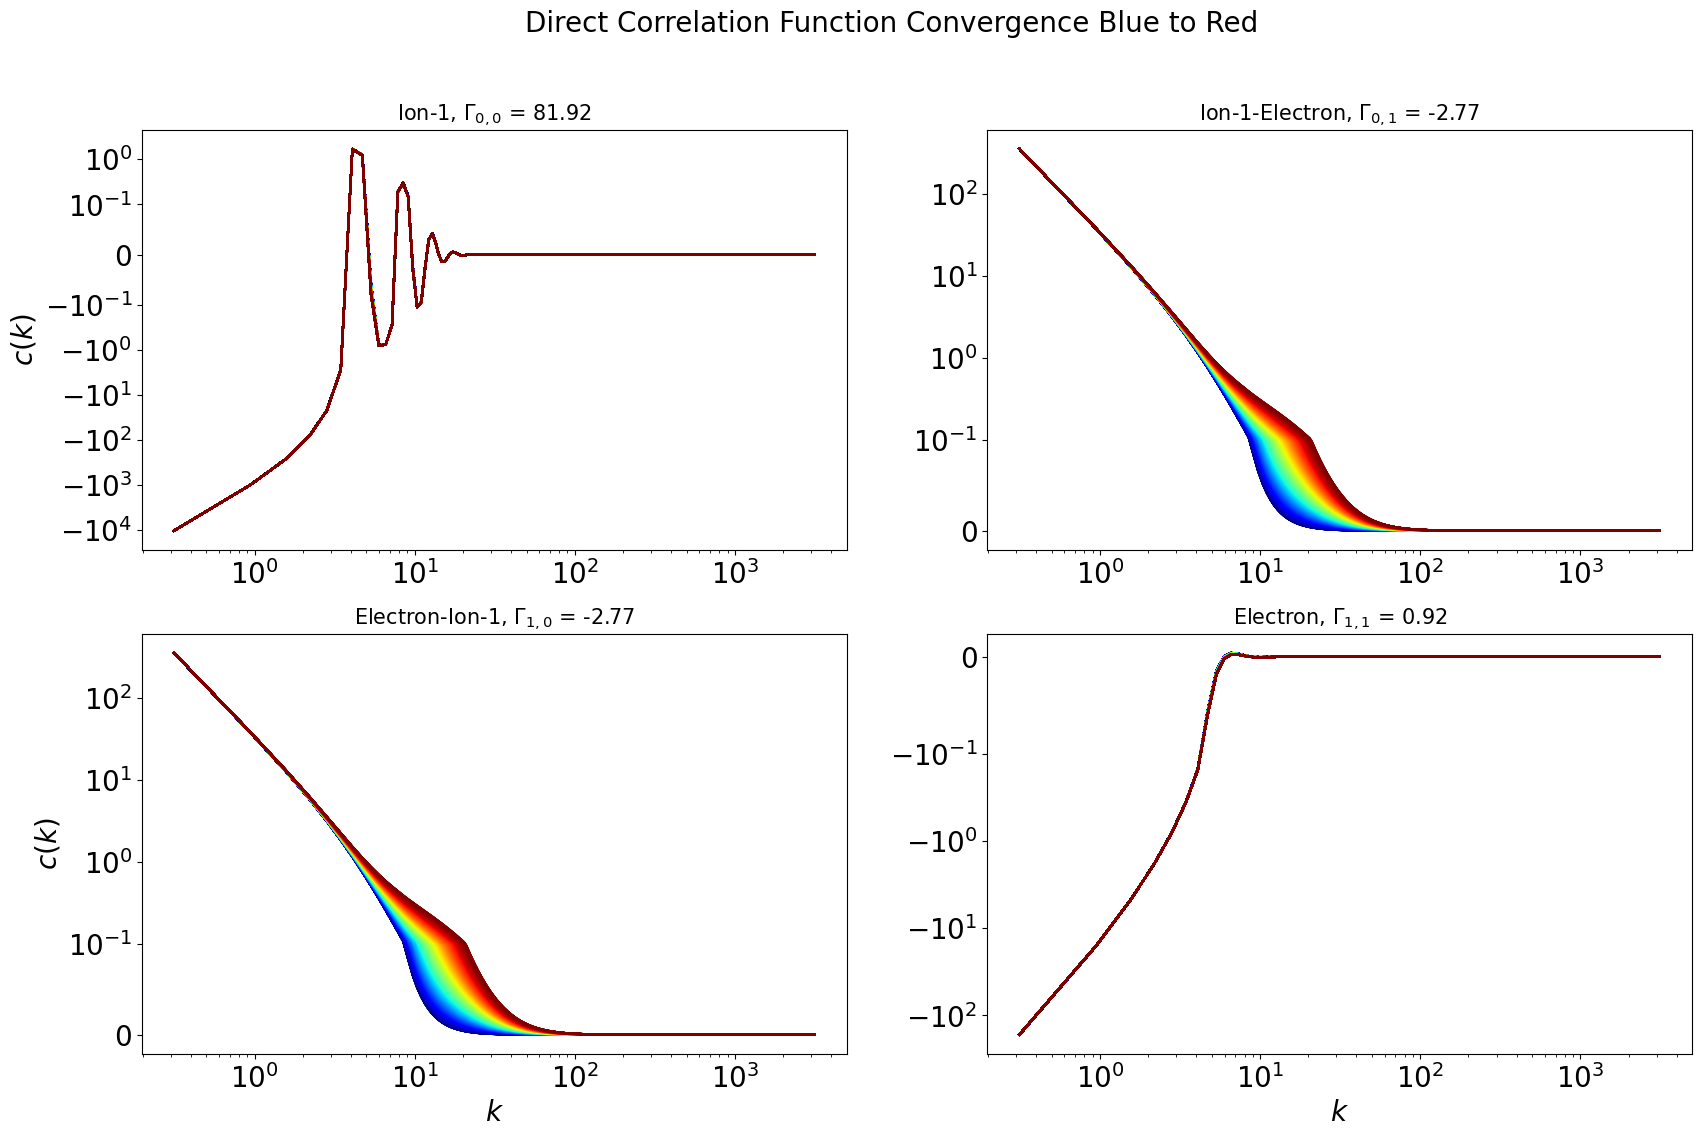

In [41]:
aluminum.plot_species_convergence_ck(n_slices= int(len(aluminum.h_list)/1)  )

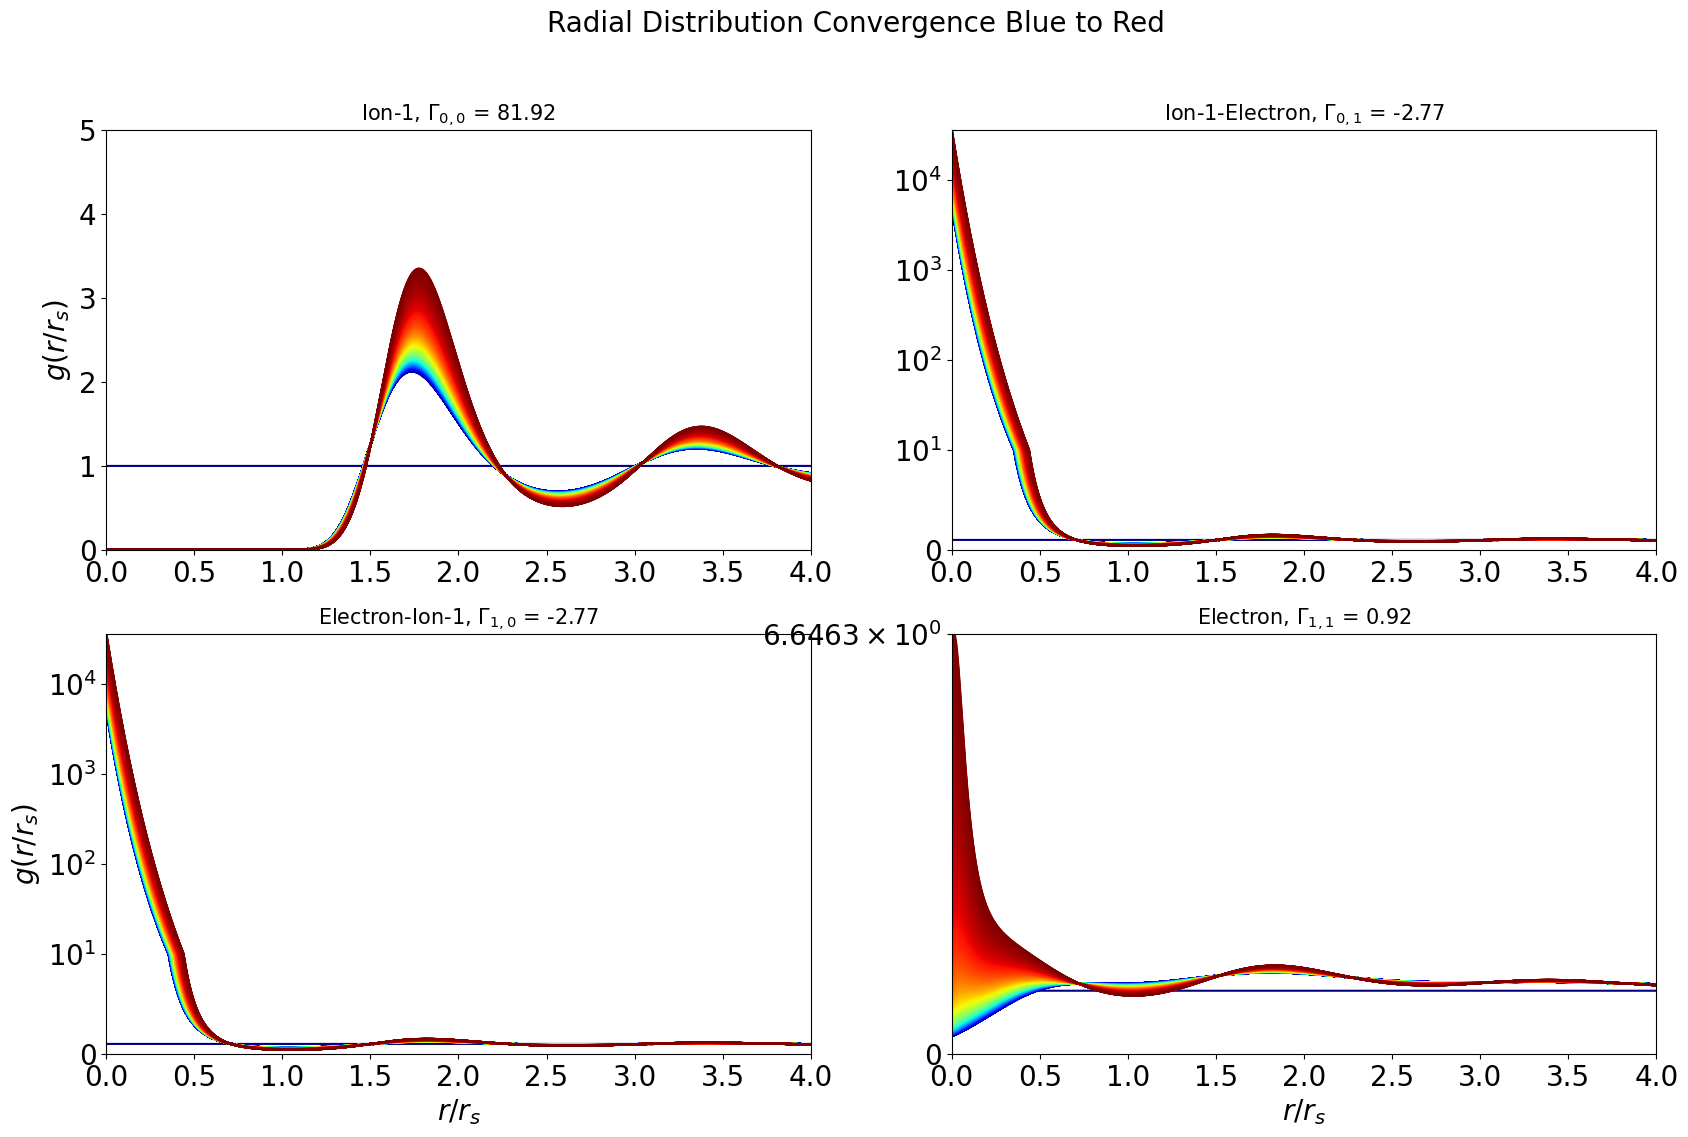

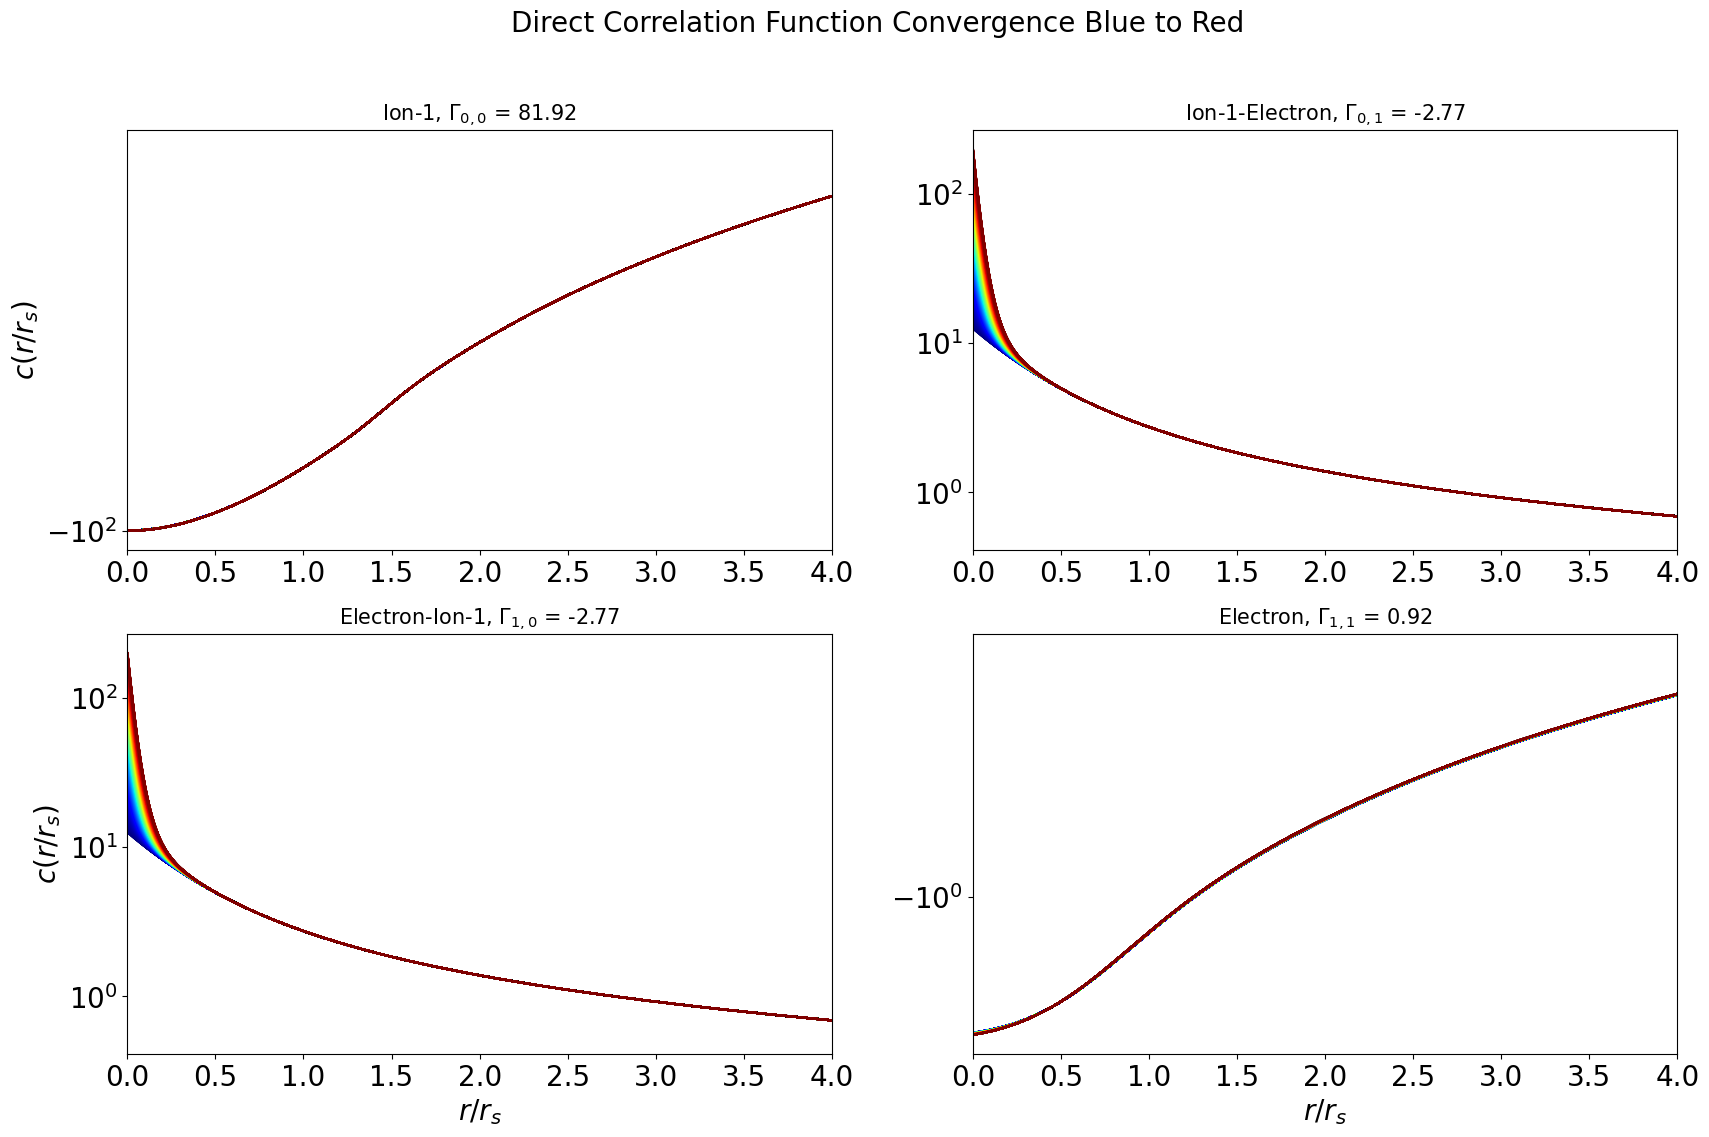

In [42]:
aluminum.plot_species_convergence_g(n_slices= int(len(aluminum.h_list)/1)  )
aluminum.plot_species_convergence_c(n_slices= int(len(aluminum.h_list)/1)  )


In [ ]:
aluminum.c_r_matrix[0,1]